# Poor Children Impact Analysis - Sigmoid/Interpolation Comparison

This notebook compares the sigmoid and two interpolation approaches to model the relationship between **Relative Wealth Index (RWI)** and **poverty rate**, constrained to match both:

1. **Target poor children count** per area classification (Rural, Urban, KMA)
2. **Quintile points** from the quintile method (weighted average RWI and poverty rate per quintile)


All methods enforce three critical constraints:

### 1. Boundary Conditions
- **RWI = -2 -> 100% poverty rate**: The poorest possible areas have 100% poverty
- **RWI = 2 -> 0% poverty rate**: The wealthiest possible areas have 0% poverty
- These boundaries ensure the function behaves reasonably at the extremes of the RWI distribution

### 2. Monotonic Decreasing
- **Poverty rate must decrease as RWI increases**: This ensures logical consistency - wealthier areas cannot have higher poverty rates than poorer areas
- **No increasing segments**: The function never increases for higher RWI values
- **No decreasing segments for lower RWI**: The function never decreases for lower RWI values

### 3. Smooth Curves
- **No sharp cuts or discontinuities**: The function should be smooth and continuous
- **No sudden drop-offs**: Gradual transitions between different RWI values


## Approaches Tested

1. **Sigmoid Function** 
   - Logistic curve with optimized parameters
   - Naturally monotonic decreasing
   - Smooth S-shaped curve

2. **Monotonic PCHIP** 
   - Piecewise Cubic Hermite Interpolating Polynomial
   - Preserves monotonicity of input data
   - Smooth interpolation that passes through all quintile points
   - Extrapolates smoothly beyond data range

3. **Akima Interpolation**
   - Smooth interpolation method
   - Less oscillatory than standard cubic splines


## Methodology

For each approach:

1. **Fit to quintile points**: Fit the function to the 5 quintile points (RWI, poverty_rate) for each region
2. **Add boundary conditions**: Ensure the function respects RWI = -2 -> 100% and RWI = 2 -> 0%
3. **Scale to match target**: Apply a scaling factor to match the target poor children count
4. **Verify monotonicity**: Check that the function remains monotonic decreasing after scaling
5. **Evaluate fit quality**: Calculate errors for both target matching and quintile point fitting

## Evaluation Metrics

- **Target Error**: Difference between achieved and target poor children count (absolute and percentage)
- **Quintile RMSE**: Root Mean Squared Error between predicted and actual poverty rates at quintile RWI values
- **Monotonicity Check**: Verification that the function is monotonic decreasing before and after scaling


## Configuration


In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Base directory where downloaded files are located
BASE_DIR = "data"

# Country identifier
COUNTRY = "JAM"

# Impact probability data configuration (optional - for calculating potentially impacted poor children)
DATE = "2025-10-27"  # Format: YYYY-MM-DD
FORECAST_TIME = "000000"  # Format: HHMMSS (e.g., "000000" for midnight, "120000" for noon)
WIND_THRESHOLDS = ["34", "50", "64"]  # List of wind thresholds in knots to compare (e.g., ["34", "50", "64"])
STORM = "MELISSA"  # Storm name

# ============================================================================
# POVERTY RATES BY CLASSIFICATION
# ============================================================================

# Moderate poverty rates (%) for children (ages 0-15) by area classification 2022
POVERTY_RATE_RURAL = 34.6460305820465
POVERTY_RATE_URBAN = 22.9166205159144
POVERTY_RATE_KMA = 34.5674892972073  # Kingston Metropolitan Area (Kingston + Saint Andrew)

POVERTY_RATES = {
    "Rural": POVERTY_RATE_RURAL,
    "Urban": POVERTY_RATE_URBAN,
    "KMA": POVERTY_RATE_KMA
}

# SMOD classification threshold (>= 20 = urban, < 20 = rural)
SMOD_URBAN_THRESHOLD = 20.0

# Kingston Metropolitan Area parishes
KMA_PARISHES = ["Kingston", "Saint Andrew"]

print("# Poverty Rates by Classification (for children ages 0-15):")
print(f"  Rural: {POVERTY_RATE_RURAL:.2f}%")
print(f"  Urban: {POVERTY_RATE_URBAN:.2f}%")
print(f"  KMA (Kingston + Saint Andrew): {POVERTY_RATE_KMA:.2f}%")
print(f"\nSMOD Urban Threshold: >= {SMOD_URBAN_THRESHOLD}")
print(f"KMA Parishes: {', '.join(KMA_PARISHES)}")

# Poverty Rates by Classification (for children ages 0-15):
  Rural: 34.65%
  Urban: 22.92%
  KMA (Kingston + Saint Andrew): 34.57%

SMOD Urban Threshold: >= 20.0
KMA Parishes: Kingston, Saint Andrew


## Import Libraries


In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import optimize, interpolate
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============================================================================
# VISUALIZATION SAVING SETUP
# ============================================================================
SAVE_VISUALIZATIONS = True
VISUALIZATIONS_DIR = "analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation"

if SAVE_VISUALIZATIONS:
    os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
    print(f"Visualizations will be saved to: {VISUALIZATIONS_DIR}/")
else:
    print("Visualization saving is disabled (set SAVE_VISUALIZATIONS = True to enable)")

# plt.show() wrapper for auto-saving
_original_show = plt.show
_figure_counter = {'count': 0}

def _show_with_save(*args, **kwargs):
    """Wrapper around plt.show() that saves meaningful figures automatically"""
    if SAVE_VISUALIZATIONS:
        fig = plt.gcf()
        axes = fig.get_axes()
        
        filename = None
        
        if axes:
            try:
                if fig._suptitle is not None:
                    suptitle = fig._suptitle.get_text()
                    if suptitle and suptitle.strip():
                        filename = suptitle.lower().replace(' ', '_').replace('\n', '_')
                        filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
            except:
                pass
            
            if not filename:
                for ax in axes:
                    try:
                        title = ax.get_title()
                        if title and title.strip():
                            filename = title.lower().replace(' ', '_').replace('\n', '_')
                            filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
                            break
                    except:
                        pass
        
        if filename:
            _figure_counter['count'] += 1
            output_file = os.path.join(VISUALIZATIONS_DIR, f"{filename}_{_figure_counter['count']}.png")
            fig.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"  Saved: {output_file}")
    
    _original_show(*args, **kwargs)

plt.show = _show_with_save


Visualizations will be saved to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/


## Load Data


In [ ]:
# Load pre-processed data
processed_file = "analysis_output/poor_children_impact_analysis_slope_opt/all_tiles_with_poor_children_flag.parquet"
if os.path.exists(processed_file):
    print("Loading pre-processed data...")
    gdf_tiles_with_admin = gpd.read_parquet(processed_file)
    if 'poverty_prob' in gdf_tiles_with_admin.columns:
        gdf_tiles_with_admin = gdf_tiles_with_admin.drop(columns=['poverty_prob'])
    print(f"Loaded {len(gdf_tiles_with_admin)} tiles")
else:
    raise FileNotFoundError("Please run the slope optimization notebook first to generate processed data")

# Load admin boundaries (same path as slope optimization notebook)
admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")
if os.path.exists(admin_base_path):
    gdf_admin = gpd.read_parquet(admin_base_path)
    print(f"\nLoaded admin boundaries: {len(gdf_admin)} parishes")
else:
    print(f"\nWarning: Admin boundaries file not found at {admin_base_path}")
    print("  Map visualizations will work without admin boundaries, but parish boundaries won't be shown")
    gdf_admin = None

# Load quintile points
quintile_rwi_file = "analysis_output/quintile_method/quintile_population_weighted_rwi_summary.csv"
df_quintile_rwi = pd.read_csv(quintile_rwi_file)

quintile_tiles_file = "analysis_output/quintile_method/tiles_with_quintile_poverty.parquet"
gdf_quintile_tiles = gpd.read_parquet(quintile_tiles_file)

# Get poverty rates per quintile per classification
quintile_poverty_rates = gdf_quintile_tiles.groupby(['area_classification', 'wealth_quintile']).agg({
    'poverty_prob': 'first'
}).reset_index()
quintile_poverty_rates.columns = ['classification', 'quintile', 'poverty_rate']

# Merge with RWI averages
df_quintile_points = df_quintile_rwi.merge(quintile_poverty_rates, 
                                            on=['classification', 'quintile'], 
                                            how='left')

print("\nQuintile Points Summary:")
for region in ['Rural', 'Urban', 'KMA']:
    region_data = df_quintile_points[df_quintile_points['classification'] == region]
    if len(region_data) > 0:
        print(f"\n{region}:")
        for _, row in region_data.sort_values('quintile').iterrows():
            q = int(row['quintile'])
            print(f"  Q{q}: RWI={row['weighted_avg_rwi']:.3f}, Poverty Rate={row['poverty_rate']}")


Loading pre-processed data...
Loaded 2224 tiles

Loaded admin boundaries: 14 parishes

Quintile Points Summary:

Rural:
  Q1: RWI=-0.281, Poverty Rate=0.6123951001957423
  Q2: RWI=0.026, Poverty Rate=0.32710384423039485
  Q3: RWI=0.245, Poverty Rate=0.2242650508265701
  Q4: RWI=0.441, Poverty Rate=0.18434075235155728
  Q5: RWI=0.785, Poverty Rate=0.11608698774569355

Urban:
  Q1: RWI=0.414, Poverty Rate=0.4307819617303414
  Q2: RWI=0.654, Poverty Rate=0.32746869548793806
  Q3: RWI=0.817, Poverty Rate=0.22668764811417494
  Q4: RWI=0.956, Poverty Rate=0.11981063303732835
  Q5: RWI=1.131, Poverty Rate=0.06623603508222804

KMA:
  Q1: RWI=0.425, Poverty Rate=0.7076172912580596
  Q2: RWI=0.824, Poverty Rate=0.48044750054168517
  Q3: RWI=0.998, Poverty Rate=0.33787232722163546
  Q4: RWI=1.190, Poverty Rate=0.17589608429936265
  Q5: RWI=1.471, Poverty Rate=0.10573253854992952


## Fitting Functions

- **Boundary conditions**: RWI = -2 → 100% poverty, RWI = 2 → 0% poverty
- **Monotonic decreasing**: Poverty rate decreases as RWI increases
- **Smooth curves**: No sharp cuts or strange drop-offs


In [4]:
# Boundary conditions
RWI_MIN = -2.0
RWI_MAX = 2.0
POVERTY_RATE_MIN = 0.0  # At RWI_MAX
POVERTY_RATE_MAX = 1.0  # At RWI_MIN

def add_boundary_points(rwi, poverty_rate):
    """
    Add boundary points: RWI=-2 -> 100%, RWI=2 -> 0%
    
    ALWAYS adds these boundary points to ensure all methods respect the boundary conditions.
    The data is sorted to ensure monotonic decreasing order.
    """
    # Ensure monotonic decreasing by sorting
    sort_idx = np.argsort(rwi)
    sorted_rwi = rwi[sort_idx]
    sorted_poverty = poverty_rate[sort_idx]
    
    # This ensures all methods respect the boundary conditions
    extended_rwi = np.concatenate([[RWI_MIN], sorted_rwi, [RWI_MAX]])
    extended_poverty = np.concatenate([[POVERTY_RATE_MAX], sorted_poverty, [POVERTY_RATE_MIN]])
    
    return extended_rwi, extended_poverty

### Sigmoid

In [5]:
def sigmoid(rwi, threshold, slope):
    """
    Sigmoid function - naturally monotonic decreasing.
    
    1 / (1 + exp(slope * (RWI - threshold)))
    - Higher slope = steeper transition
    - threshold = RWI value where poverty rate = 50%
    - Naturally bounded between 0 and 1
    """
    return 1.0 / (1.0 + np.exp(slope * (rwi - threshold)))


def fit_sigmoid(quintile_rwi, quintile_poverty):
    """
    Fit sigmoid to quintile points with boundary constraints
    
    1. Weighted fitting: Weight quintile points by importance (Q1 and Q5 weighted more)
    2. Initial guess: Use linear regression to estimate threshold
    3. Multiple optimization attempts: Try different initial guesses and methods
    4. Adaptive boundary penalty: Adjust penalty weight based on data range
    
    Strategy: Fit sigmoid to quintile points only (not boundary points),
    but add a soft penalty to encourage boundary compliance.
    """
    # Calculate weights: weight Q1 and Q5 more
    n_points = len(quintile_rwi)
    weights = np.ones(n_points)
    weights[0] = 2.0  # Q1 (poorest)
    weights[-1] = 2.0  # Q5 (wealthiest)
    weights = weights / weights.sum() * n_points  # Normalize so sum = n_points
    
    # Calculate data range to adjust boundary penalty
    rwi_range = quintile_rwi.max() - quintile_rwi.min()
    # If data is far from boundaries, use smaller penalty
    dist_to_boundary_min = abs(quintile_rwi.min() - RWI_MIN)
    dist_to_boundary_max = abs(quintile_rwi.max() - RWI_MAX)
    avg_boundary_dist = (dist_to_boundary_min + dist_to_boundary_max) / 2
    # Adaptive penalty: smaller when boundaries are far
    boundary_weight = 0.1 * min(1.0, rwi_range / avg_boundary_dist)
    
    def objective(params):
        threshold, slope = params
        predicted = sigmoid(quintile_rwi, threshold, slope)
        
        # Weighted error: prioritize quintile points, especially extremes
        quintile_error = np.sum(weights * (predicted - quintile_poverty) ** 2)
        
        # Boundary compliance penalty (adaptive weight)
        boundary_pred_min = sigmoid(RWI_MIN, threshold, slope)
        boundary_pred_max = sigmoid(RWI_MAX, threshold, slope)
        boundary_error = ((boundary_pred_min - POVERTY_RATE_MAX) ** 2 + 
                         (boundary_pred_max - POVERTY_RATE_MIN) ** 2)
        
        return quintile_error + boundary_weight * boundary_error
    
    # Better initial guess using linear regression
    # Transform poverty rate to logit space for linear fit
    # Avoid log(0) and log(1) by clipping
    eps = 1e-6
    poverty_clipped = np.clip(quintile_poverty, eps, 1 - eps)
    logit_poverty = np.log(poverty_clipped / (1 - poverty_clipped))
    
    # Linear fit: logit(poverty) ≈ slope * (RWI - threshold)
    # So: logit_poverty ≈ slope * RWI - slope * threshold
    # Therefore: threshold ≈ RWI - logit_poverty / slope
    # First estimate slope from linear regression
    if len(quintile_rwi) > 1:
        # Simple linear regression: logit_poverty = a * RWI + b
        # slope ≈ -a, threshold ≈ -b/a
        coeffs = np.polyfit(quintile_rwi, logit_poverty, 1)
        estimated_slope = abs(coeffs[0])  # Should be positive (decreasing)
        estimated_threshold = -coeffs[1] / coeffs[0] if coeffs[0] != 0 else np.median(quintile_rwi)
        # Clip to reasonable bounds
        estimated_threshold = np.clip(estimated_threshold, -2.0, 2.0)
        estimated_slope = np.clip(estimated_slope, 0.5, 8.0)
    else:
        estimated_threshold = np.median(quintile_rwi)
        estimated_slope = 2.0
    
    # Try multiple optimization strategies
    best_result = None
    best_error = np.inf
    
    # Strategy 1: Use estimated parameters
    initial_guesses = [
        [estimated_threshold, estimated_slope],
        [np.median(quintile_rwi), 2.0],
        [np.median(quintile_rwi), 1.0],
        [np.median(quintile_rwi), 4.0],
        [quintile_rwi[0], 2.0],  # Start at Q1
        [quintile_rwi[-1], 2.0],  # Start at Q5
    ]
    
    methods = ['L-BFGS-B', 'TNC', 'SLSQP']
    
    for x0 in initial_guesses:
        for method in methods:
            try:
                result = optimize.minimize(
                    objective,
                    x0=x0,
                    method=method,
                    bounds=[(-2.0, 2.0), (0.1, 10.0)],
                    options={'maxiter': 1000, 'ftol': 1e-9}
                )
                if result.success:
                    error = objective(result.x)
                    if error < best_error:
                        best_error = error
                        best_result = result
            except:
                continue
    
    # Fallback to simple L-BFGS-B if all failed
    if best_result is None:
        best_result = optimize.minimize(
            objective,
            x0=[estimated_threshold, estimated_slope],
            method='L-BFGS-B',
            bounds=[(-2.0, 2.0), (0.1, 10.0)]
        )
    
    return {'threshold': best_result.x[0], 'slope': best_result.x[1]}

def predict_sigmoid(rwi, params):
    """Predict using sigmoid - naturally monotonic"""
    predicted = sigmoid(rwi, params['threshold'], params['slope'])
    # Clip to [0, 1] and ensure boundary conditions
    predicted = np.clip(predicted, 0, 1)
    # Only enforce boundaries at exact boundary values to avoid plateaus
    # For sigmoid, it should naturally approach boundaries smoothly
    boundary_mask_min = rwi <= RWI_MIN
    boundary_mask_max = rwi >= RWI_MAX
    predicted[boundary_mask_min] = POVERTY_RATE_MAX
    predicted[boundary_mask_max] = POVERTY_RATE_MIN
    return predicted

### Monotonic PCHIP

In [6]:
def fit_monotonic_pchip(quintile_rwi, quintile_poverty):
    """
    Fit monotonic PCHIP to quintile points with boundary conditions.
    """
    # Add boundary points to the fit
    extended_rwi, extended_poverty = add_boundary_points(quintile_rwi, quintile_poverty)
    
    # PCHIP automatically preserves monotonicity
    pchip = interpolate.PchipInterpolator(extended_rwi, extended_poverty)
    return {'pchip': pchip}

def predict_monotonic_pchip(rwi, params):
    """
    Predict using monotonic PCHIP interpolation.
    
    PCHIP interpolates smoothly within the fitted range and we enforce
    boundary conditions for values outside the range.
    """
    pchip = params['pchip']
    predicted = np.zeros_like(rwi)
    
    # Get the interpolation range from the fitted points
    rwi_min_fitted = pchip.x[0]  # Should be RWI_MIN
    rwi_max_fitted = pchip.x[-1]  # Should be RWI_MAX
    
    # Below minimum: enforce boundary condition (100% poverty)
    below_min = rwi < rwi_min_fitted
    predicted[below_min] = POVERTY_RATE_MAX
    
    # Above maximum: enforce boundary condition (0% poverty)
    above_max = rwi > rwi_max_fitted
    predicted[above_max] = POVERTY_RATE_MIN
    
    # Within interpolation range: use PCHIP
    in_range = ~(below_min | above_max)
    if np.any(in_range):
        predicted[in_range] = pchip(rwi[in_range])
    
    # Ensure values stay in valid range [0, 1]
    predicted = np.clip(predicted, 0, 1)
    
    # Strictly enforce boundary conditions
    predicted[rwi <= RWI_MIN] = POVERTY_RATE_MAX
    predicted[rwi >= RWI_MAX] = POVERTY_RATE_MIN
    
    return predicted

### Monotonic interpolation with Akima

In [7]:
def fit_akima(quintile_rwi, quintile_poverty):
    """
    Fit Akima interpolation with boundary conditions.
    
    Akima interpolation is smooth and less oscillatory than standard cubic splines.
    """
    # Add boundary points to the fit
    extended_rwi, extended_poverty = add_boundary_points(quintile_rwi, quintile_poverty)
    
    # Akima interpolation
    akima = interpolate.Akima1DInterpolator(extended_rwi, extended_poverty)
    return {'akima': akima}

def predict_akima(rwi, params):
    """
    Predict using Akima interpolation.
    
    Handles extrapolation by enforcing boundary conditions.
    Since boundary points are included in the fit, interpolation should cover the range.
    """
    akima = params['akima']
    predicted = np.zeros_like(rwi)
    
    # Get the interpolation range from the fitted points
    rwi_min_fitted = akima.x[0]  # Should be RWI_MIN
    rwi_max_fitted = akima.x[-1]  # Should be RWI_MAX
    
    # Below minimum: enforce boundary condition (100% poverty)
    below_min = rwi < rwi_min_fitted
    predicted[below_min] = POVERTY_RATE_MAX
    
    # Above maximum: enforce boundary condition (0% poverty)
    above_max = rwi > rwi_max_fitted
    predicted[above_max] = POVERTY_RATE_MIN
    
    # Within interpolation range: use Akima
    in_range = ~(below_min | above_max)
    if np.any(in_range):
        predicted[in_range] = akima(rwi[in_range])
    
    # Ensure values stay in valid range [0, 1]
    predicted = np.clip(predicted, 0, 1)
    
    # Strictly enforce boundary conditions
    predicted[rwi <= RWI_MIN] = POVERTY_RATE_MAX
    predicted[rwi >= RWI_MAX] = POVERTY_RATE_MIN
    
    return predicted

In [8]:
FITTING_METHODS = {
    'Sigmoid': {
        'fit': fit_sigmoid,
        'predict': predict_sigmoid,
    },
    'Monotonic PCHIP': {
        'fit': fit_monotonic_pchip,
        'predict': predict_monotonic_pchip,
    },
    'Akima Interpolation': {
        'fit': fit_akima,
        'predict': predict_akima,
    }
}

## Fit and Scale Functions

Fits each method (regression or interpolation) to quintile points (with boundary conditions), then scales the predictions to match the target poor children count.

### Scaling Process

The scaling process works as follows:

1. **Fit function to quintile points**: Each method fits a curve through the 5 quintile points (plus boundary points)
2. **Calculate base predictions**: Predict poverty rates for all tiles in the region
3. **Calculate current total**: Sum of (predicted_rate x children_population) for all tiles
4. **Calculate scale factor**: `scale_factor = target_poor_children / current_total`
5. **Apply scaling**: Multiply all predictions by the scale factor
6. **Clip to valid range**: Ensure all predictions stay within [0, 1]

### Monotonicity Verification
Verify monotonicity both before and after scaling:
- **Before scaling**: Check that the fitted function is monotonic decreasing
- **After scaling**: Verify that scaling didn't break monotonicity.


In [9]:
def verify_monotonicity(rwi, poverty_rate):
    """
    Verify that poverty rate is monotonic decreasing with RWI.
    RWI_i < RWI_j implies poverty_rate_i >= poverty_rate_j
    Check this by sorting by RWI and verifying all differences are <= 0
    """
    # Sort by RWI to check monotonicity
    sort_idx = np.argsort(rwi)
    sorted_rwi = rwi[sort_idx]
    sorted_poverty = poverty_rate[sort_idx]
    
    # Check if decreasing (all differences should be <= 0)
    diffs = np.diff(sorted_poverty)
    is_monotonic = np.all(diffs <= 1e-10)  # Allow small numerical errors
    
    return is_monotonic, np.max(diffs) if len(diffs) > 0 else 0

def scale_to_match_target(predict_func, params, df_region, target_poor_children):
    """
    Scale the predicted poverty rates to match target poor children count.
    Uses a scaling factor applied to all predictions.
    Preserves monotonicity (scaling by constant preserves monotonicity).
    """
    rwi_values = df_region['rwi'].values
    pop_values = df_region['children_population'].values
    
    # Get base predictions
    base_predictions = predict_func(rwi_values, params)
    
    # Verify monotonicity before scaling
    is_mono_before, max_diff_before = verify_monotonicity(rwi_values, base_predictions)
    
    # Calculate current total poor children
    current_total = np.sum(base_predictions * pop_values)
    
    if current_total == 0:
        # If all predictions are 0, use uniform scaling
        scale_factor = target_poor_children / np.sum(pop_values)
    else:
        # Scale factor to match target
        scale_factor = target_poor_children / current_total
    
    # Apply scaling (but keep in [0, 1])
    scaled_predictions = np.clip(base_predictions * scale_factor, 0, 1)
    
    # Verify monotonicity after scaling
    is_mono_after, max_diff_after = verify_monotonicity(rwi_values, scaled_predictions)
    
    return scaled_predictions, scale_factor, is_mono_before, is_mono_after

# Fit all methods for each region
poverty_rate_map = {
    'Rural': POVERTY_RATE_RURAL / 100,
    'Urban': POVERTY_RATE_URBAN / 100,
    'KMA': POVERTY_RATE_KMA / 100
}

all_results = {}

for region in ['Rural', 'Urban', 'KMA']:
    print(f"\n{'='*80}")
    print(f"Region: {region}")
    print(f"{'='*80}")
    
    # Filter region data
    mask = gdf_tiles_with_admin['area_classification'] == region
    df_region = gdf_tiles_with_admin[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Calculate target
    total_pop = df_region['children_population'].sum()
    target_poor = total_pop * poverty_rate_map[region]
    
    # Get quintile points
    region_quintile_points = df_quintile_points[df_quintile_points['classification'] == region].copy()
    region_quintile_points = region_quintile_points.sort_values('quintile')
    
    quintile_rwi = region_quintile_points['weighted_avg_rwi'].values
    quintile_poverty = region_quintile_points['poverty_rate'].values
    
    region_results = {}

    # Try each method
    for method_name, method_funcs in FITTING_METHODS.items():
        try:
            # Fit to quintile points
            fit_params = method_funcs['fit'](quintile_rwi, quintile_poverty)
            
            # Scale to match target
            scaled_predictions, scale_factor, mono_before, mono_after = scale_to_match_target(
                method_funcs['predict'],
                fit_params,
                df_region,
                target_poor
            )
            
            # Calculate errors
            achieved_poor = np.sum(scaled_predictions * df_region['children_population'].values)
            children_error = abs(achieved_poor - target_poor)
            children_error_pct = (children_error / target_poor * 100) if target_poor > 0 else 0
            
            # Quintile fit error (on SCALED predictions)
            # Note: For interpolation methods, unscaled predictions pass exactly through quintile points (RMSE=0)
            # But after scaling, they may not align perfectly
            quintile_predictions_unscaled = method_funcs['predict'](quintile_rwi, fit_params)
            quintile_predictions_scaled = np.clip(quintile_predictions_unscaled * scale_factor, 0, 1)
            quintile_error = np.sum((quintile_predictions_scaled - quintile_poverty) ** 2)
            quintile_rmse = np.sqrt(np.mean((quintile_predictions_scaled - quintile_poverty) ** 2))
            
            # Store quintile predictions for debugging (store both unscaled and scaled)
            quintile_predictions_dict = {q: (rwi, pred_unscaled, pred_scaled, actual) for q, rwi, pred_unscaled, pred_scaled, actual in 
                                        zip(region_quintile_points['quintile'].values,
                                            quintile_rwi, quintile_predictions_unscaled, quintile_predictions_scaled, quintile_poverty)}
            
            # Calculate base total before scaling (for diagnostics)
            base_predictions_for_diag = method_funcs['predict'](df_region['rwi'].values, fit_params)
            base_total = np.sum(base_predictions_for_diag * df_region['children_population'].values)
            
            region_results[method_name] = {
                'params': fit_params,
                'predictions': scaled_predictions,
                'scale_factor': scale_factor,
                'target_poor_children': target_poor,
                'achieved_poor_children': achieved_poor,
                'children_error': children_error,
                'children_error_pct': children_error_pct,
                'quintile_error': quintile_error,
                'quintile_rmse': quintile_rmse,
                'monotonic_before': mono_before,
                'monotonic_after': mono_after,
                'predict_func': method_funcs['predict']
            }
            
            print(f"\n{method_name}:")
            print(f"  Target: {target_poor:,.0f}, Achieved: {achieved_poor:,.0f}")
            print(f"  Error: {children_error:.2f} ({children_error_pct:.4f}%)")
            print(f"  Quintile RMSE: {quintile_rmse:.6f}")
            print(f"  Scale factor: {scale_factor:.4f}")
            print(f"  Monotonic: Before={mono_before}, After={mono_after}")
            print(f"    Quintile fit details (scaled):")
            for q in sorted(quintile_predictions_dict.keys()):
                rwi_q, pred_unscaled_q, pred_scaled_q, actual_q = quintile_predictions_dict[q]
                error_q = abs(pred_scaled_q - actual_q)
                print(f"      Q{q}: RWI={rwi_q:.3f}, Predicted (scaled)={pred_scaled_q:.3f}, Actual={actual_q:.3f}, Error={error_q:.3f}")
            
        except Exception as e:
            print(f"\n{method_name}: FAILED - {str(e)}")
            continue
    
    all_results[region] = region_results



Region: Rural

Sigmoid:
  Target: 142,572, Achieved: 142,565
  Error: 6.45 (0.0045%)
  Quintile RMSE: 0.075329
  Scale factor: 1.1738
  Monotonic: Before=True, After=True
    Quintile fit details (scaled):
      Q1: RWI=-0.281, Predicted (scaled)=0.689, Actual=0.612, Error=0.077
      Q2: RWI=0.026, Predicted (scaled)=0.451, Actual=0.327, Error=0.124
      Q3: RWI=0.245, Predicted (scaled)=0.302, Actual=0.224, Error=0.078
      Q4: RWI=0.441, Predicted (scaled)=0.200, Actual=0.184, Error=0.015
      Q5: RWI=0.785, Predicted (scaled)=0.088, Actual=0.116, Error=0.028

Monotonic PCHIP:
  Target: 142,572, Achieved: 142,569
  Error: 2.70 (0.0019%)
  Quintile RMSE: 0.069364
  Scale factor: 1.2037
  Monotonic: Before=True, After=True
    Quintile fit details (scaled):
      Q1: RWI=-0.281, Predicted (scaled)=0.737, Actual=0.612, Error=0.125
      Q2: RWI=0.026, Predicted (scaled)=0.394, Actual=0.327, Error=0.067
      Q3: RWI=0.245, Predicted (scaled)=0.270, Actual=0.224, Error=0.046
      Q

## Visualize results

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/rural_comparison_of_fitting_methods_1.png


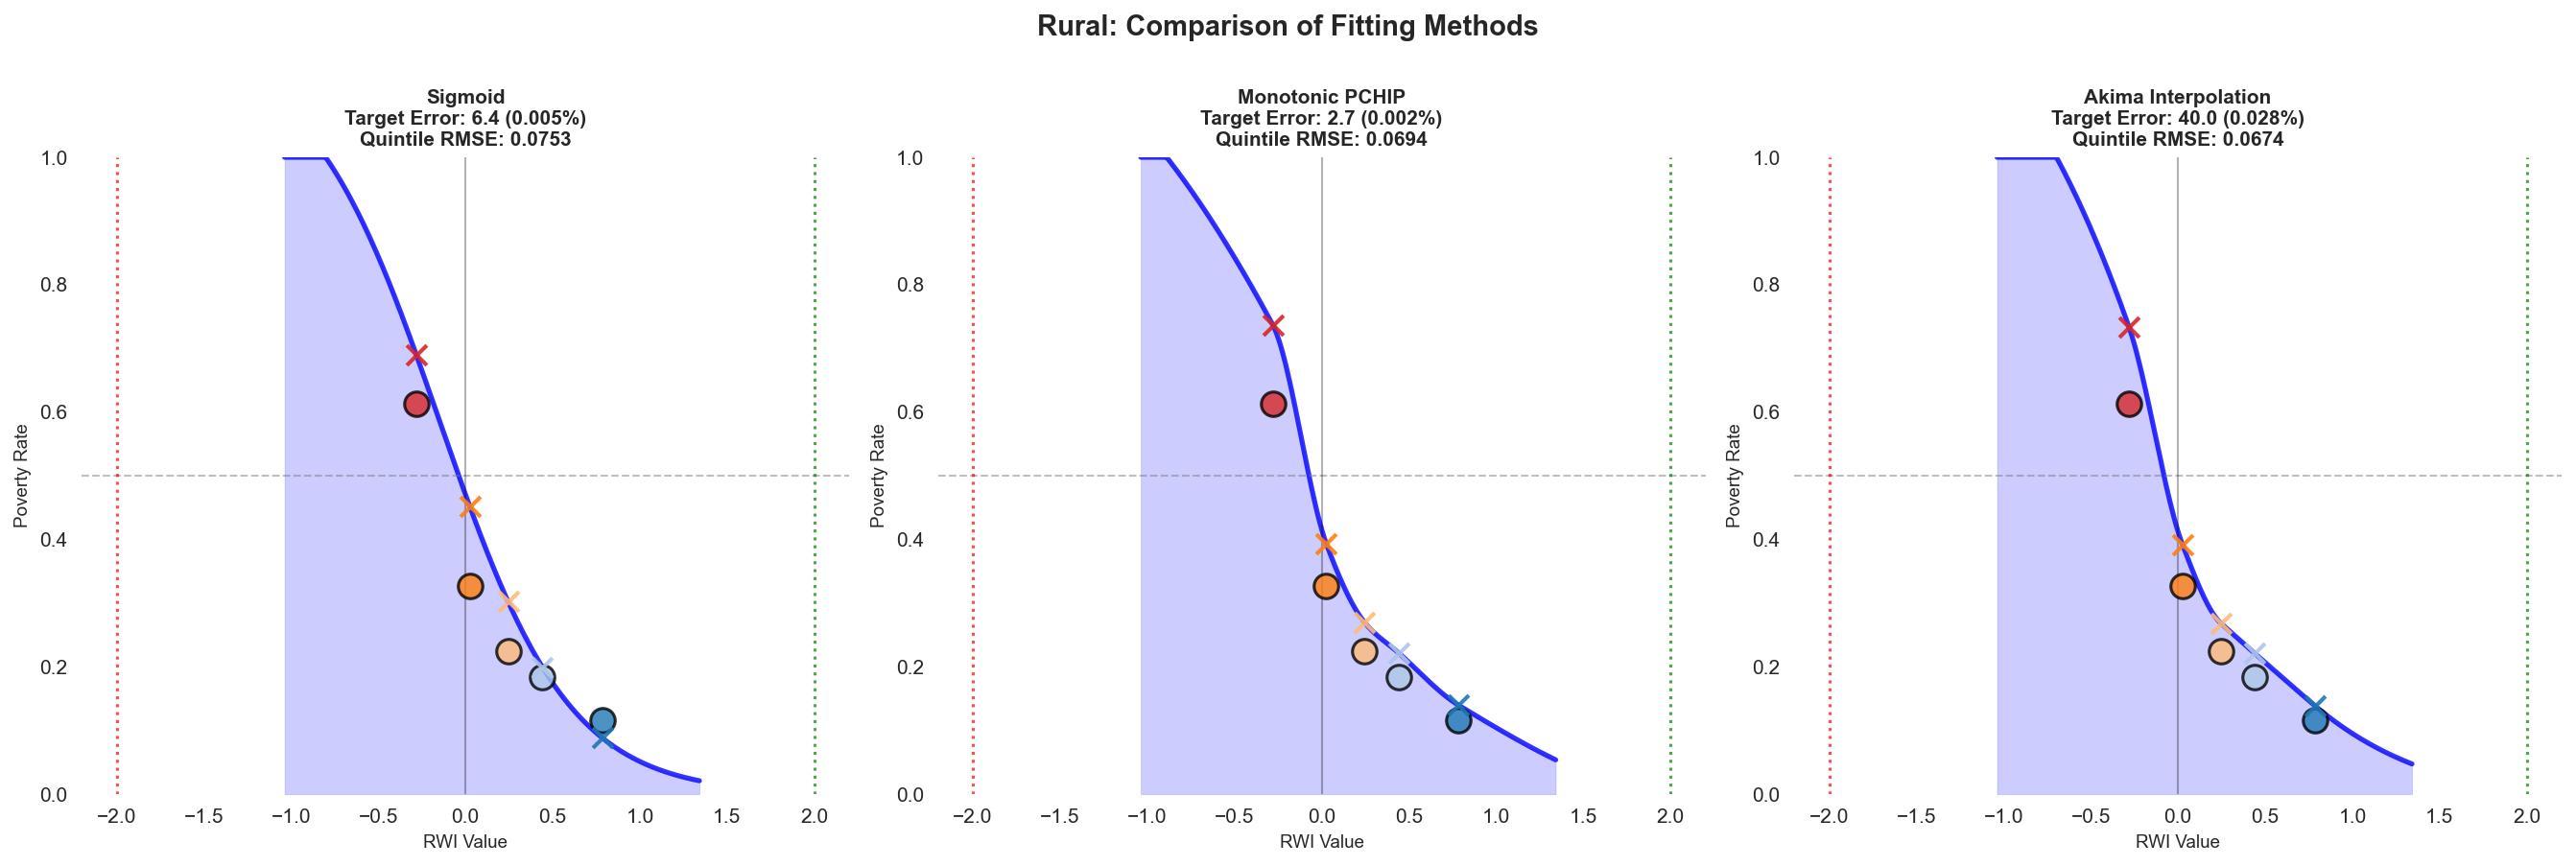

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/urban_comparison_of_fitting_methods_2.png


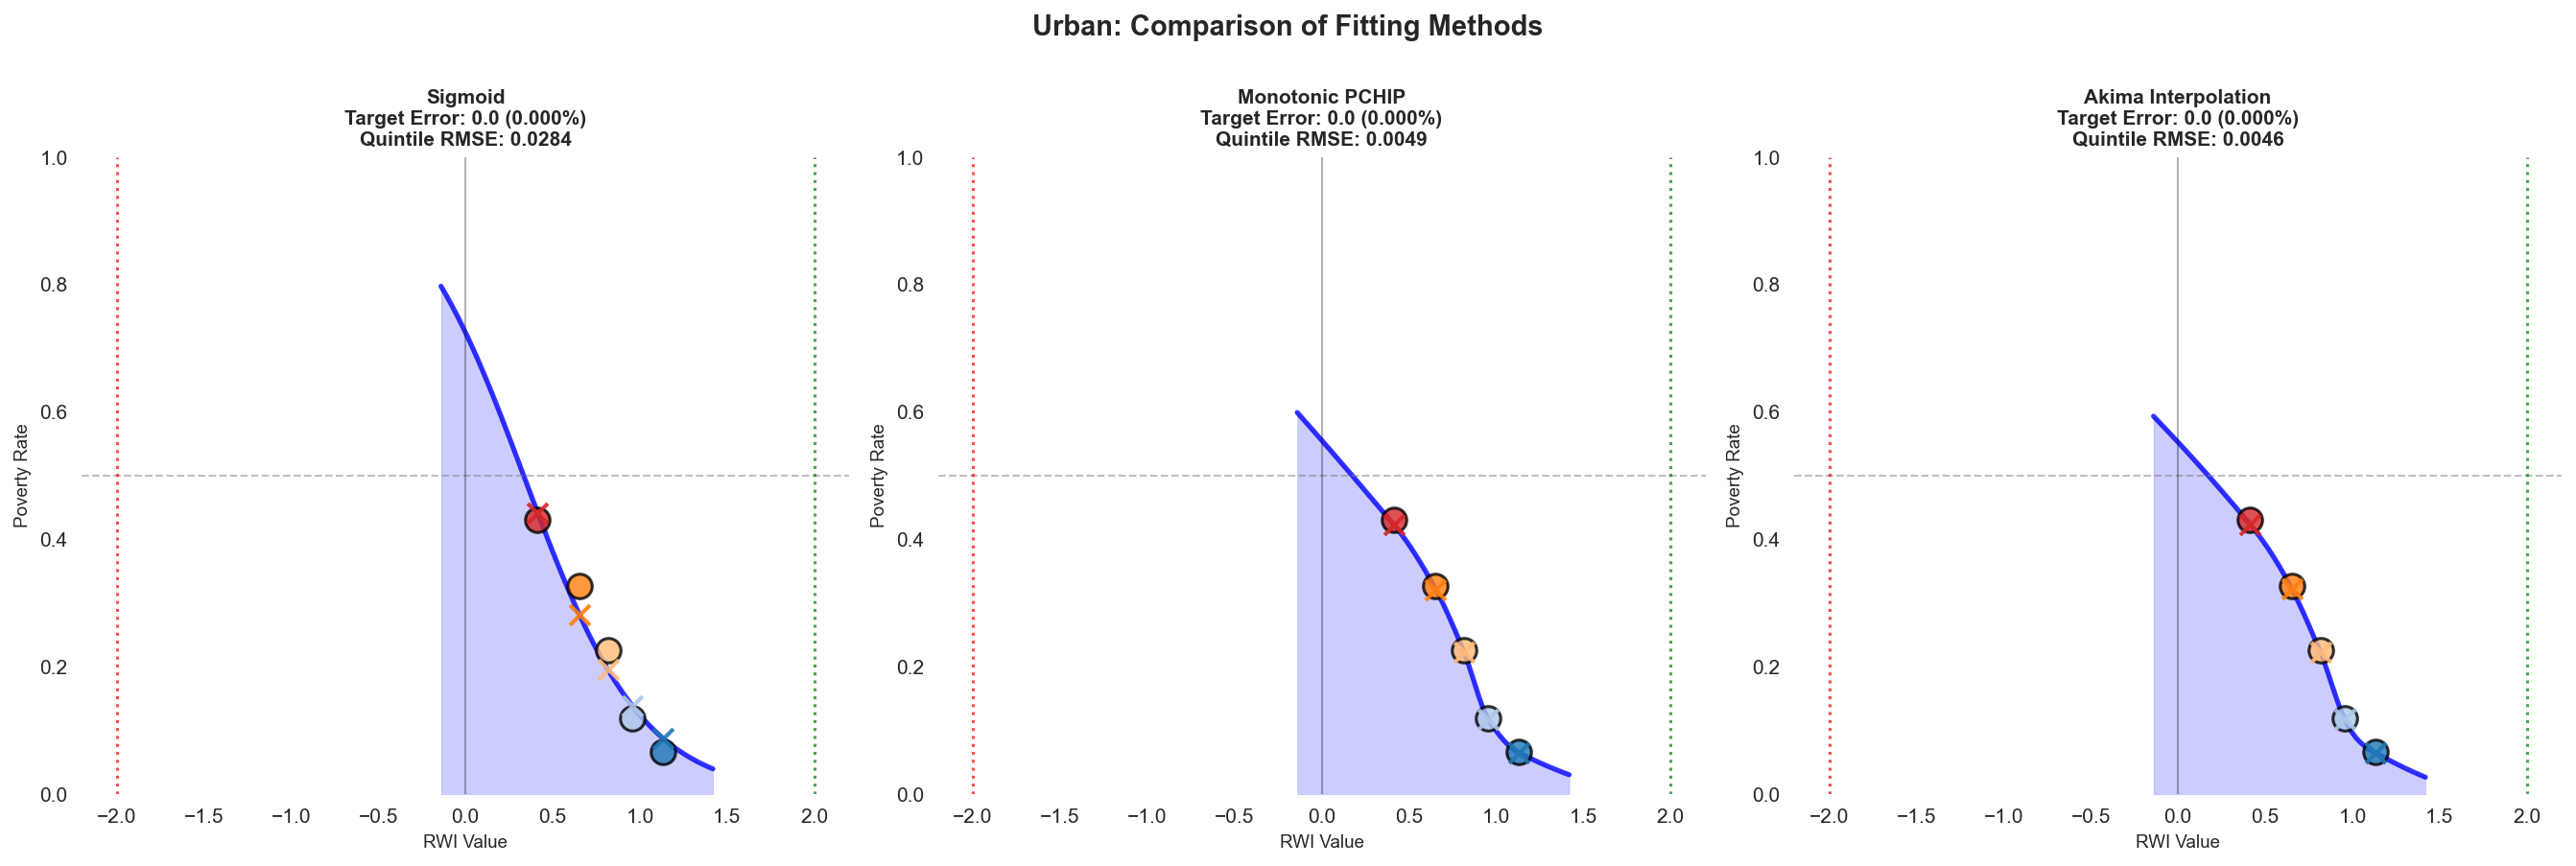

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/kma_comparison_of_fitting_methods_3.png


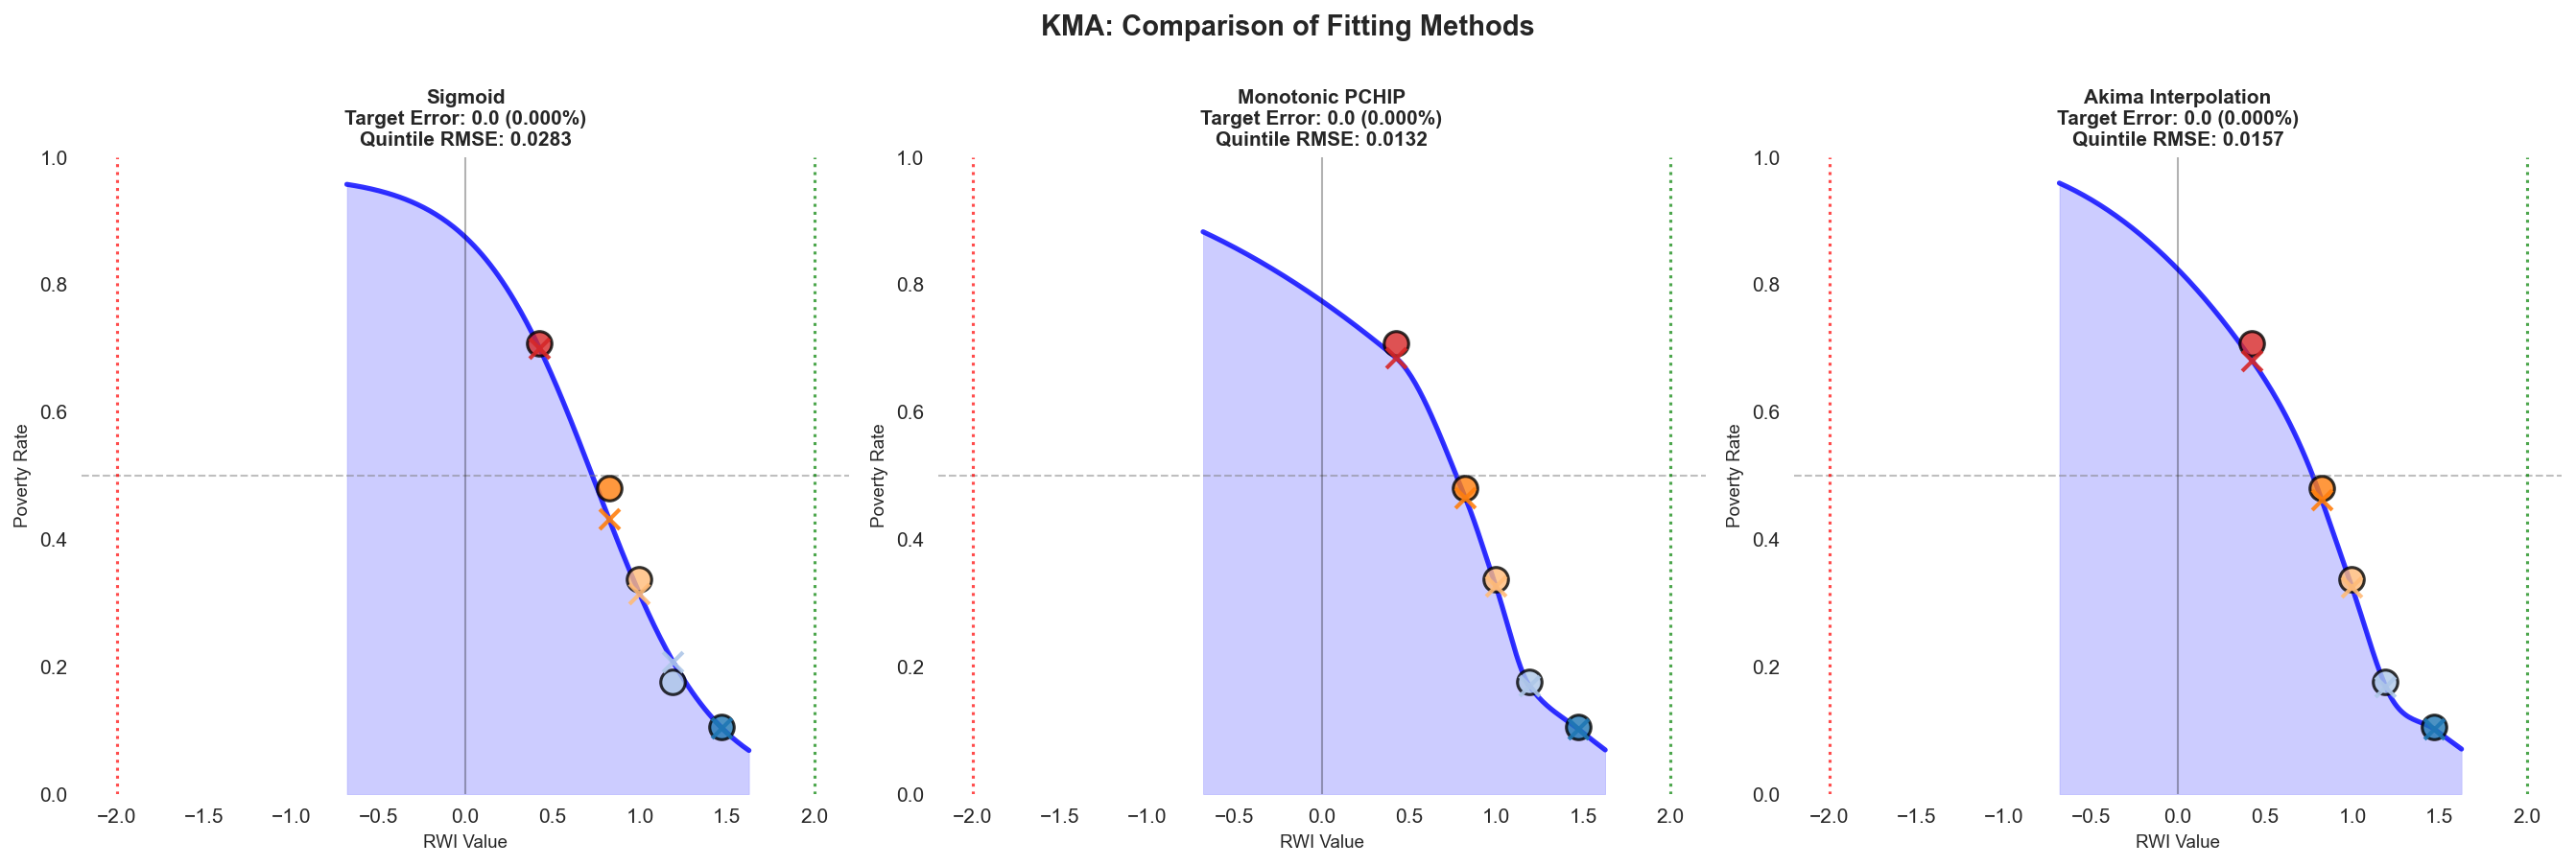

In [10]:
# Color scheme for quintiles
quintile_colors = {
    1: '#d62728',  # Red - Poorest
    2: '#ff7f0e',  # Orange
    3: '#ffbb78',  # Light Orange
    4: '#aec7e8',  # Light Blue
    5: '#1f77b4'   # Blue - Richest
}

# Plot all methods for each region
for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue
    
    region_results = all_results[region]
    mask = gdf_tiles_with_admin['area_classification'] == region
    df_region = gdf_tiles_with_admin[mask].copy()
    
    # Get quintile points
    region_quintile_points = df_quintile_points[df_quintile_points['classification'] == region]
    
    # Create subplots - 2 rows, 3 columns
    n_methods = len(region_results)
    n_cols = 3
    n_rows = (n_methods + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Extend RWI range to show boundary conditions
    rwi_min_plot = max(df_region['rwi'].min(), RWI_MIN - 0.2)
    rwi_max_plot = min(df_region['rwi'].max(), RWI_MAX + 0.2)
    rwi_range = np.linspace(rwi_min_plot, rwi_max_plot, 200)
    
    for idx, (method_name, result) in enumerate(region_results.items()):
        ax = axes[idx]
        
        # Get predictions for the full RWI range (before scaling)
        base_predictions = result['predict_func'](rwi_range, result['params'])
        
        # Apply scaling
        scale_factor = result['scale_factor']
        scaled_predictions = np.clip(base_predictions * scale_factor, 0, 1)
        
        # Plot curve
        ax.plot(rwi_range, scaled_predictions, 'b-', linewidth=2.5, 
                label=f'{method_name}', alpha=0.8)
        ax.fill_between(rwi_range, 0, scaled_predictions, alpha=0.2, color='blue')
        
        # Plot quintile points
        for _, row in region_quintile_points.iterrows():
            q = int(row['quintile'])
            rwi_avg = row['weighted_avg_rwi']
            poverty_rate = row['poverty_rate']
            
            if pd.notna(rwi_avg) and pd.notna(poverty_rate):
                # Actual quintile point
                ax.scatter(rwi_avg, poverty_rate, 
                          s=150, marker='o', 
                          color=quintile_colors[q], 
                          edgecolor='black', linewidth=1.5,
                          zorder=5, alpha=0.8)
                
                # Predicted value
                predicted_rate = result['predict_func'](np.array([rwi_avg]), result['params'])[0]
                predicted_rate_scaled = np.clip(predicted_rate * scale_factor, 0, 1)
                ax.scatter(rwi_avg, predicted_rate_scaled,
                          s=100, marker='x', 
                          color=quintile_colors[q],
                          linewidth=2, zorder=6, alpha=0.9)
        
        # Add reference lines
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
        ax.axvline(x=RWI_MIN, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='Boundary: RWI=-2')
        ax.axvline(x=RWI_MAX, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label='Boundary: RWI=2')
        
        # Title with metrics
        ax.set_title(f'{method_name}\n'
                     f'Target Error: {result["children_error"]:.1f} ({result["children_error_pct"]:.3f}%)\n'
                     f'Quintile RMSE: {result["quintile_rmse"]:.4f}',
                     fontsize=10, fontweight='bold')
        ax.set_xlabel('RWI Value', fontsize=9)
        ax.set_ylabel('Poverty Rate', fontsize=9)
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(region_results), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{region}: Comparison of Fitting Methods',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

## Comparison Table

- **Target_Error**: Absolute difference between achieved and target poor children count
- **Target_Error_Pct**: Percentage error (Target_Error / Target x 100%)
- **Quintile_RMSE**: Root Mean Squared Error between predicted and actual poverty rates at quintile points
- **Scale_Factor**: The scaling factor applied to match the target (1.0 = no scaling needed)

### Best Method Selection

The best method for each region is selected based on a combined score:
- Normalized Target Error Percentage + Normalized Quintile RMSE
- Lower combined score = better overall performance


In [11]:
# Create summary comparison table
summary_data = []

for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue
    
    region_results = all_results[region]
    for method_name, result in region_results.items():
        summary_data.append({
            'Region': region,
            'Method': method_name,
            'Target_Error': result['children_error'],
            'Target_Error_Pct': result['children_error_pct'],
            'Quintile_RMSE': result['quintile_rmse'],
            'Scale_Factor': result['scale_factor']
        })

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("Summary Comparison Table")
print("="*100)
print(df_summary.to_string(index=False))

# Find best method for each region based on combined score
print("\n" + "="*100)
print("Best Method per Region (based on combined score: Target Error % + Quintile RMSE)")
print("="*100)

for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue
    
    region_data = df_summary[df_summary['Region'] == region].copy()
    if len(region_data) == 0:
        continue
    
    # Combined score (normalized)
    region_data['Combined_Score'] = (
        region_data['Target_Error_Pct'] / region_data['Target_Error_Pct'].max() +
        region_data['Quintile_RMSE'] / region_data['Quintile_RMSE'].max()
    )
    
    best_method = region_data.loc[region_data['Combined_Score'].idxmin()]
    
    print(f"\n{region}:")
    print(f"  Best Method: {best_method['Method']}")
    print(f"  Target Error: {best_method['Target_Error']:.2f} ({best_method['Target_Error_Pct']:.4f}%)")
    print(f"  Quintile RMSE: {best_method['Quintile_RMSE']:.6f}")
    print(f"  Combined Score: {best_method['Combined_Score']:.4f}")



Summary Comparison Table
Region              Method  Target_Error  Target_Error_Pct  Quintile_RMSE  Scale_Factor
 Rural             Sigmoid  6.446728e+00      4.521737e-03       0.075329      1.173808
 Rural     Monotonic PCHIP  2.697809e+00      1.892244e-03       0.069364      1.203699
 Rural Akima Interpolation  3.999899e+01      2.805531e-02       0.067419      1.197986
 Urban             Sigmoid  7.275958e-12      1.278072e-14       0.028417      0.991755
 Urban     Monotonic PCHIP  7.275958e-12      1.278072e-14       0.004898      0.981821
 Urban Akima Interpolation  7.275958e-12      1.278072e-14       0.004596      0.982942
   KMA             Sigmoid  7.275958e-12      1.132341e-14       0.028251      0.972022
   KMA     Monotonic PCHIP  2.182787e-11      3.397024e-14       0.013198      0.968681
   KMA Akima Interpolation  1.455192e-11      2.264683e-14       0.015721      0.962691

Best Method per Region (based on combined score: Target Error % + Quintile RMSE)

Rural:
  Be

## Save Results

In [12]:
output_dir = "analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation"
os.makedirs(output_dir, exist_ok=True)

# Export Method Comparison Summary Table
# ----------------------------------------------------------------------------
# CSV file containing performance metrics for all methods across all regions
# Columns: Region, Method, Target_Error, Target_Error_Pct, Quintile_RMSE, Scale_Factor
# Used to compare how well each method (Sigmoid, PCHIP, Akima) performs
summary_file = os.path.join(output_dir, "method_comparison_summary.csv")
df_summary.to_csv(summary_file, index=False)
print(f"Exported method comparison summary to: {summary_file}")

# Export All Methods' Predictions per Region (with Best Method Flag)
# ----------------------------------------------------------------------------
# For each region (Rural, Urban, KMA), export all tiles with poverty probabilities
# from ALL methods (Sigmoid, PCHIP, Akima), and flag which method is best
# Files: {region}_all_methods.parquet
# Contains: 
#   - All tile geometries
#   - poverty_prob_sigmoid: Predictions from sigmoid method
#   - poverty_prob_pchip: Predictions from PCHIP method
#   - poverty_prob_akima: Predictions from Akima method
#   - poverty_prob_best: Predictions from best method (for convenience)
#   - best_method: Name of the best method for this region
#   - is_best_method: Boolean flag (True for best method column)

best_methods = {}
for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue

    region_data = df_summary[df_summary['Region'] == region].copy()
    if len(region_data) == 0:
        continue

    # Calculate combined score to select best method
    region_data['Combined_Score'] = (
        region_data['Target_Error_Pct'] / region_data['Target_Error_Pct'].max() +
        region_data['Quintile_RMSE'] / region_data['Quintile_RMSE'].max()
    )

    best_method_name = region_data.loc[region_data['Combined_Score'].idxmin(), 'Method']
    best_methods[region] = best_method_name

    # Get tiles for this region
    mask = gdf_tiles_with_admin['area_classification'] == region
    gdf_region = gdf_tiles_with_admin[mask].copy()
    
    # Add predictions from all methods
    region_results = all_results[region]
    for method_name in region_results.keys():
        # Create clean column name (lowercase, replace spaces with underscores)
        col_name = f"poverty_prob_{method_name.lower().replace(' ', '_')}"
        gdf_region[col_name] = region_results[method_name]['predictions']
    
    # Add best method predictions and flag
    best_col_name = f"poverty_prob_{best_method_name.lower().replace(' ', '_')}"
    gdf_region['poverty_prob_best'] = gdf_region[best_col_name]
    gdf_region['best_method'] = best_method_name
    
    # Add boolean flag for each method indicating if it's the best
    for method_name in region_results.keys():
        col_name = f"poverty_prob_{method_name.lower().replace(' ', '_')}"
        flag_col = f"is_best_{method_name.lower().replace(' ', '_')}"
        gdf_region[flag_col] = (method_name == best_method_name)

    # Export tiles with all methods' predictions
    output_file = os.path.join(output_dir, f"{region.lower()}_all_methods.parquet")
    gdf_region.to_parquet(output_file, index=False)
    print(f"Exported {region} tiles with all methods (best: {best_method_name}) to: {output_file}")


Exported method comparison summary to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/method_comparison_summary.csv
Exported Rural tiles with all methods (best: Monotonic PCHIP) to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/rural_all_methods.parquet
Exported Urban tiles with all methods (best: Akima Interpolation) to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/urban_all_methods.parquet
Exported KMA tiles with all methods (best: Akima Interpolation) to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/kma_all_methods.parquet


# SELECT METHODS AND TEST

In [13]:
METHOD_SELECTION = {
    'Rural': 'best',  # Options: 'best', 'Sigmoid', 'Monotonic PCHIP', 'Akima Interpolation'
    'Urban': 'best',  # Options: 'best', 'Sigmoid', 'Monotonic PCHIP', 'Akima Interpolation'
    'KMA': 'best'     # Options: 'best', 'Sigmoid', 'Monotonic PCHIP', 'Akima Interpolation'
}

# If 'best' is selected, use the best method from the comparison
# Otherwise, use the specified method
selected_methods = {}
for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue
    
    if METHOD_SELECTION[region] == 'best':
        # Use the best method from the comparison
        region_data = df_summary[df_summary['Region'] == region].copy()
        if len(region_data) == 0:
            continue
        
        # Calculate combined score
        target_error_max = region_data['Target_Error_Pct'].max()
        quintile_rmse_max = region_data['Quintile_RMSE'].max()
        
        if target_error_max > 0 and not np.isnan(target_error_max):
            normalized_target_error = region_data['Target_Error_Pct'] / target_error_max
        else:
            normalized_target_error = pd.Series(0.0, index=region_data.index)
        
        if quintile_rmse_max > 0 and not np.isnan(quintile_rmse_max):
            normalized_quintile_rmse = region_data['Quintile_RMSE'] / quintile_rmse_max
        else:
            normalized_quintile_rmse = pd.Series(0.0, index=region_data.index)
        
        region_data['Combined_Score'] = normalized_target_error + normalized_quintile_rmse
        valid_scores = region_data['Combined_Score'].dropna()
        
        if len(valid_scores) > 0:
            best_idx = valid_scores.idxmin()
            selected_methods[region] = region_data.loc[best_idx, 'Method']
        else:
            # Fallback to first available method
            selected_methods[region] = list(all_results[region].keys())[0]
    else:
        # Use the specified method
        if METHOD_SELECTION[region] in all_results[region]:
            selected_methods[region] = METHOD_SELECTION[region]
        else:
            print(f"Warning: Method '{METHOD_SELECTION[region]}' not available for {region}. Using best method instead.")
            # Fallback to best method
            region_data = df_summary[df_summary['Region'] == region].copy()
            if len(region_data) > 0:
                target_error_max = region_data['Target_Error_Pct'].max()
                quintile_rmse_max = region_data['Quintile_RMSE'].max()
                
                if target_error_max > 0 and not np.isnan(target_error_max):
                    normalized_target_error = region_data['Target_Error_Pct'] / target_error_max
                else:
                    normalized_target_error = pd.Series(0.0, index=region_data.index)
                
                if quintile_rmse_max > 0 and not np.isnan(quintile_rmse_max):
                    normalized_quintile_rmse = region_data['Quintile_RMSE'] / quintile_rmse_max
                else:
                    normalized_quintile_rmse = pd.Series(0.0, index=region_data.index)
                
                region_data['Combined_Score'] = normalized_target_error + normalized_quintile_rmse
                valid_scores = region_data['Combined_Score'].dropna()
                
                if len(valid_scores) > 0:
                    best_idx = valid_scores.idxmin()
                    selected_methods[region] = region_data.loc[best_idx, 'Method']
                else:
                    selected_methods[region] = list(all_results[region].keys())[0]

print("Selected methods per region:")
for region, method in selected_methods.items():
    print(f"  {region}: {method}")

# Calculate poor children per tile using selected methods
gdf_tiles_with_poor_children = gdf_tiles_with_admin.copy()
gdf_tiles_with_poor_children['poverty_prob'] = np.nan
gdf_tiles_with_poor_children['poor_children'] = 0.0
gdf_tiles_with_poor_children['selected_method'] = ''

for region in ['Rural', 'Urban', 'KMA']:
    if region not in selected_methods:
        continue
    
    method_name = selected_methods[region]
    mask = gdf_tiles_with_poor_children['area_classification'] == region
    
    if method_name in all_results[region]:
        # Get predictions from the selected method
        predictions = all_results[region][method_name]['predictions']
        gdf_tiles_with_poor_children.loc[mask, 'poverty_prob'] = predictions
        gdf_tiles_with_poor_children.loc[mask, 'selected_method'] = method_name
        
        # Calculate poor children = poverty_prob * children_population
        gdf_tiles_with_poor_children.loc[mask, 'poor_children'] = (
            gdf_tiles_with_poor_children.loc[mask, 'poverty_prob'] * 
            gdf_tiles_with_poor_children.loc[mask, 'children_population']
        )

print(f"\nTotal poor children calculated: {gdf_tiles_with_poor_children['poor_children'].sum():,.0f}")
print(f"\nPoor children by region:")
for region in ['Rural', 'Urban', 'KMA']:
    mask = gdf_tiles_with_poor_children['area_classification'] == region
    total = gdf_tiles_with_poor_children.loc[mask, 'poor_children'].sum()
    print(f"  {region}: {total:,.0f}")


Selected methods per region:
  Rural: Monotonic PCHIP
  Urban: Akima Interpolation
  KMA: Akima Interpolation

Total poor children calculated: 263,754

Poor children by region:
  Rural: 142,569
  Urban: 56,929
  KMA: 64,256


## Simple Poor Children Distribution Map


  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/poor_children_distribution_per_tile_poor_children__poverty_rate__children_population_4.png


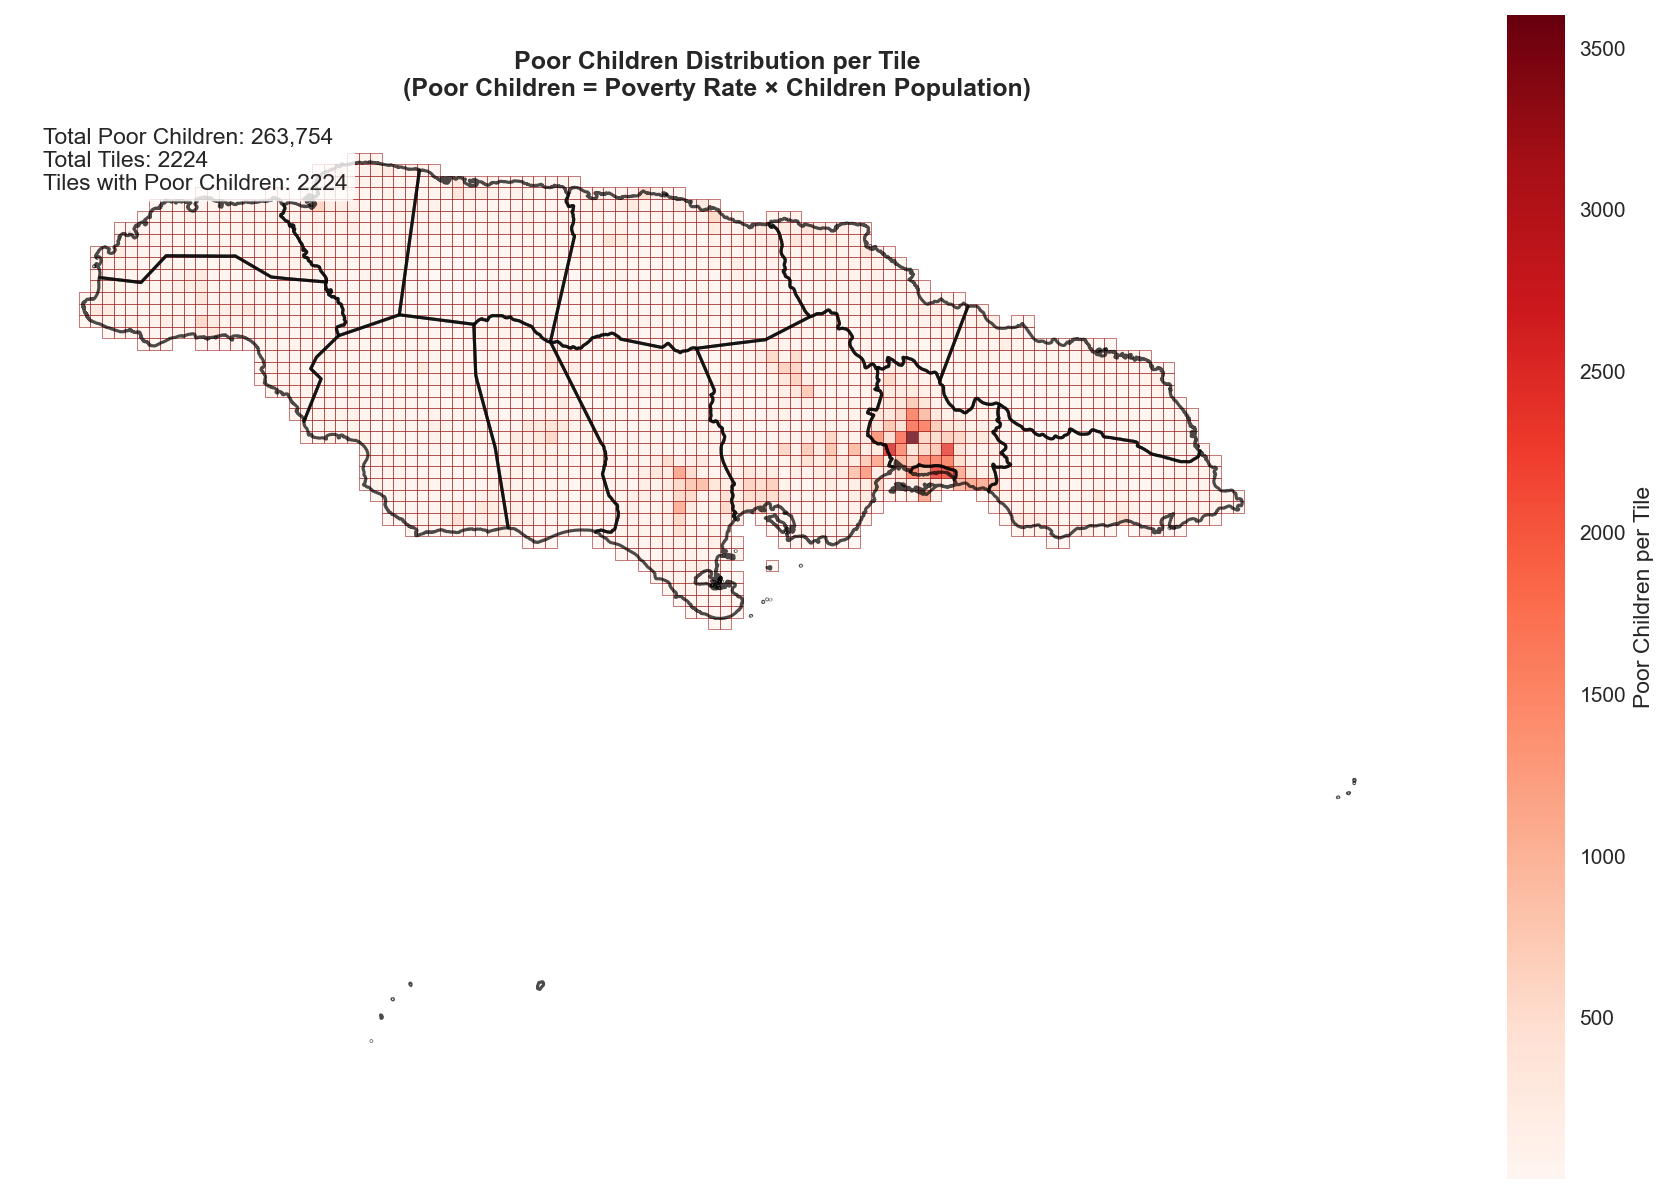

In [14]:
# Create simple map showing number of poor children per tile
fig, ax = plt.subplots(figsize=(12, 10))

gdf_tiles_with_poor_children.plot(
    column='poor_children',
    cmap='Reds',  # Red = More Poor Children
    legend=True,
    legend_kwds={'label': 'Poor Children per Tile', 'shrink': 0.8},
    ax=ax,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=0.3
)

# Plot admin boundaries if available
if 'gdf_admin' in locals() and gdf_admin is not None:
    gdf_admin.plot(ax=ax, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)

ax.set_title("Poor Children Distribution per Tile\n(Poor Children = Poverty Rate × Children Population)", 
             fontsize=12, fontweight='bold')
ax.axis('off')

# Add summary statistics
total_poor = gdf_tiles_with_poor_children['poor_children'].sum()
total_tiles = len(gdf_tiles_with_poor_children)
tiles_with_poor = (gdf_tiles_with_poor_children['poor_children'] > 0).sum()

ax.text(0.02, 0.98, 
        f'Total Poor Children: {total_poor:,.0f}\nTotal Tiles: {total_tiles}\nTiles with Poor Children: {tiles_with_poor}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


## Spatial Distribution Comparison Map


  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/spatial_distribution_poor_children_poverty_rates_population_and_rwi_5.png


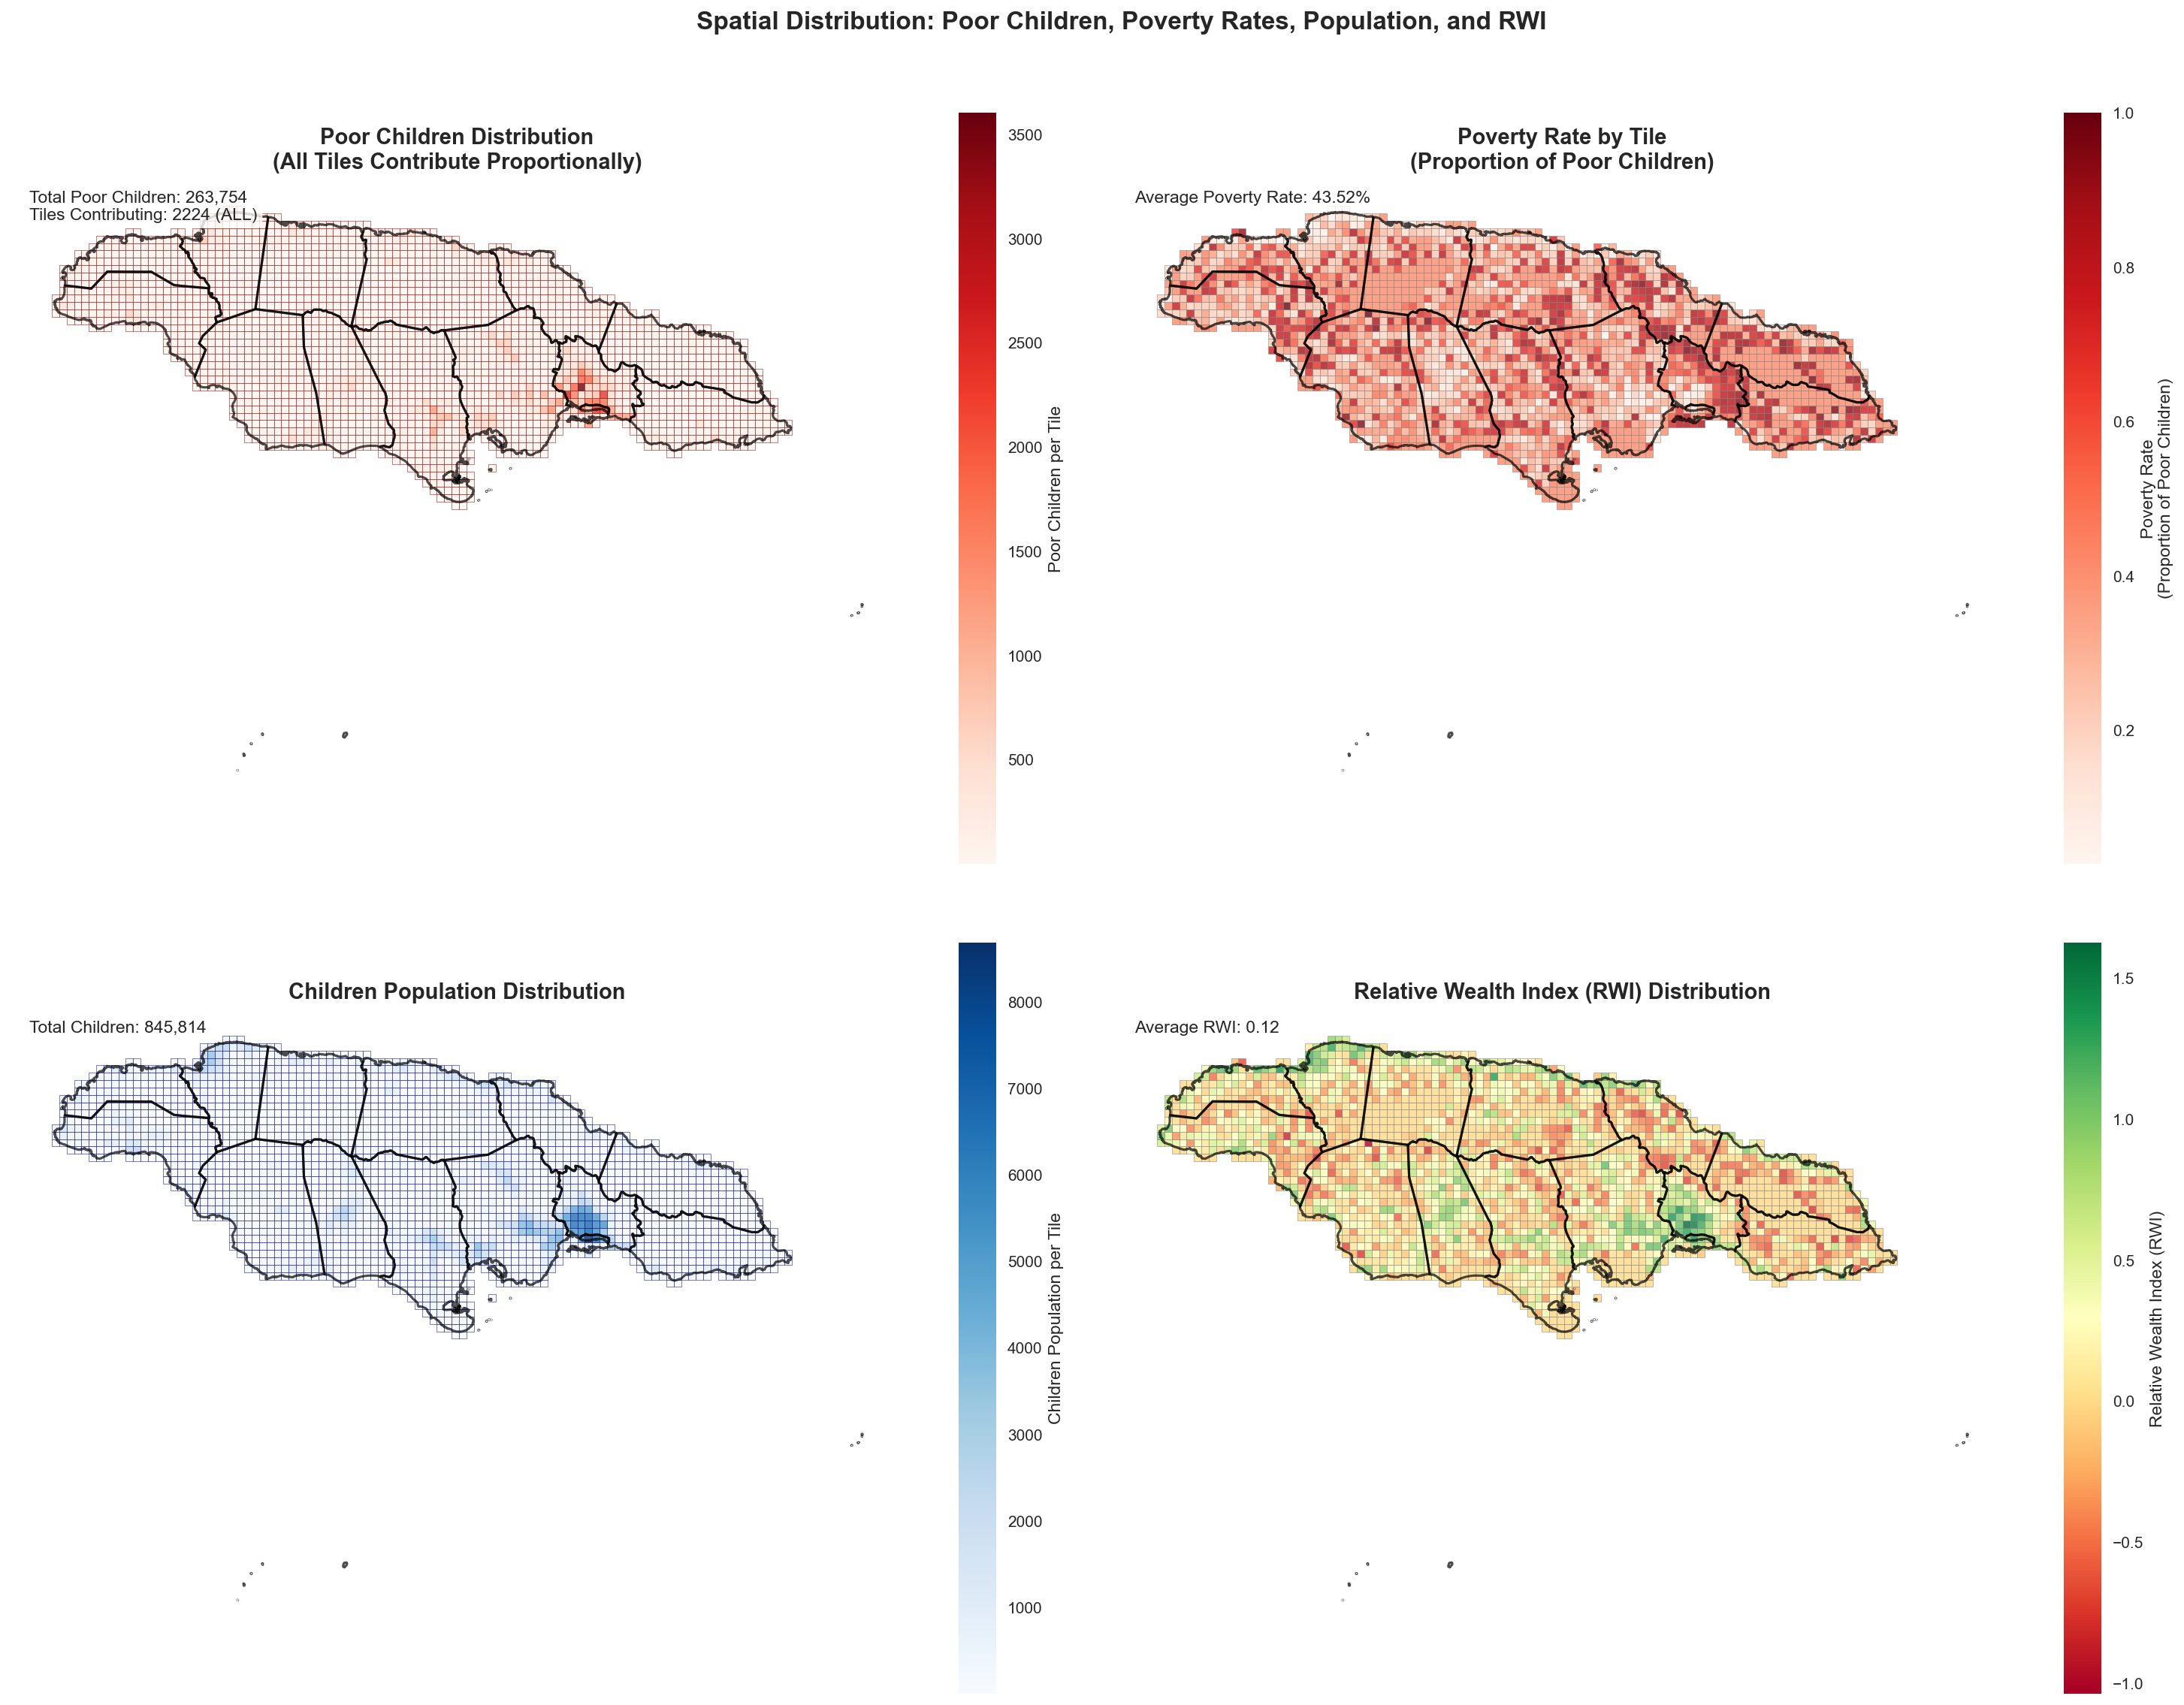

In [ ]:
# Create 2x2 comparison map
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Get admin boundaries for context
if gdf_admin is not None:
    gdf_admin_plot = gdf_admin.copy()
else:
    gdf_admin_plot = None

# 1. Poor Children Distribution Map
ax1 = axes[0, 0]
gdf_tiles_with_poor_children.plot(
    column='poor_children',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Poor Children per Tile', 'shrink': 0.8},
    ax=ax1,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=0.3
)
if gdf_admin_plot is not None:
    gdf_admin_plot.plot(ax=ax1, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax1.set_title('Poor Children Distribution\n(All Tiles Contribute Proportionally)', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# Add summary text
total_poor = gdf_tiles_with_poor_children['poor_children'].sum()
total_tiles = len(gdf_tiles_with_poor_children)
tiles_with_poor = (gdf_tiles_with_poor_children['poor_children'] > 0).sum()
ax1.text(0.02, 0.98, 
         f'Total Poor Children: {total_poor:,.0f}\nTiles Contributing: {total_tiles} (ALL)',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Poverty Rate Map
ax2 = axes[0, 1]
gdf_tiles_with_poor_children.plot(
    column='poverty_prob',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Poverty Rate\n(Proportion of Poor Children)', 'shrink': 0.8},
    ax=ax2,
    alpha=0.8,
    edgecolor='gray',
    linewidth=0.3
)
if gdf_admin_plot is not None:
    gdf_admin_plot.plot(ax=ax2, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax2.set_title('Poverty Rate by Tile\n(Proportion of Poor Children)', 
              fontsize=14, fontweight='bold')
ax2.axis('off')

# Add summary text
avg_poverty_rate = gdf_tiles_with_poor_children['poverty_prob'].mean()
ax2.text(0.02, 0.98, 
         f'Average Poverty Rate: {avg_poverty_rate:.2%}',
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Children Population Map
ax3 = axes[1, 0]
gdf_tiles_with_poor_children.plot(
    column='children_population',
    cmap='Blues',
    legend=True,
    legend_kwds={'label': 'Children Population per Tile', 'shrink': 0.8},
    ax=ax3,
    alpha=0.8,
    edgecolor='darkblue',
    linewidth=0.3
)
if gdf_admin_plot is not None:
    gdf_admin_plot.plot(ax=ax3, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax3.set_title('Children Population Distribution', 
              fontsize=14, fontweight='bold')
ax3.axis('off')

# Add summary text
total_children = gdf_tiles_with_poor_children['children_population'].sum()
ax3.text(0.02, 0.98, 
         f'Total Children: {total_children:,.0f}',
         transform=ax3.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. RWI Distribution Map
ax4 = axes[1, 1]
gdf_tiles_with_poor_children.plot(
    column='rwi',
    cmap='RdYlGn',
    legend=True,
    legend_kwds={'label': 'Relative Wealth Index (RWI)', 'shrink': 0.8},
    ax=ax4,
    alpha=0.8,
    edgecolor='gray',
    linewidth=0.3
)
if gdf_admin_plot is not None:
    gdf_admin_plot.plot(ax=ax4, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax4.set_title('Relative Wealth Index (RWI) Distribution', 
              fontsize=14, fontweight='bold')
ax4.axis('off')

# Add summary text
avg_rwi = gdf_tiles_with_poor_children['rwi'].mean()
ax4.text(0.02, 0.98, 
         f'Average RWI: {avg_rwi:.2f}',
         transform=ax4.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('Spatial Distribution: Poor Children, Poverty Rates, Population, and RWI', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


##Poor Children Distribution by RWI


  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/poor_children_distribution_by_rwi_all_tiles_contribute_proportionally_6.png


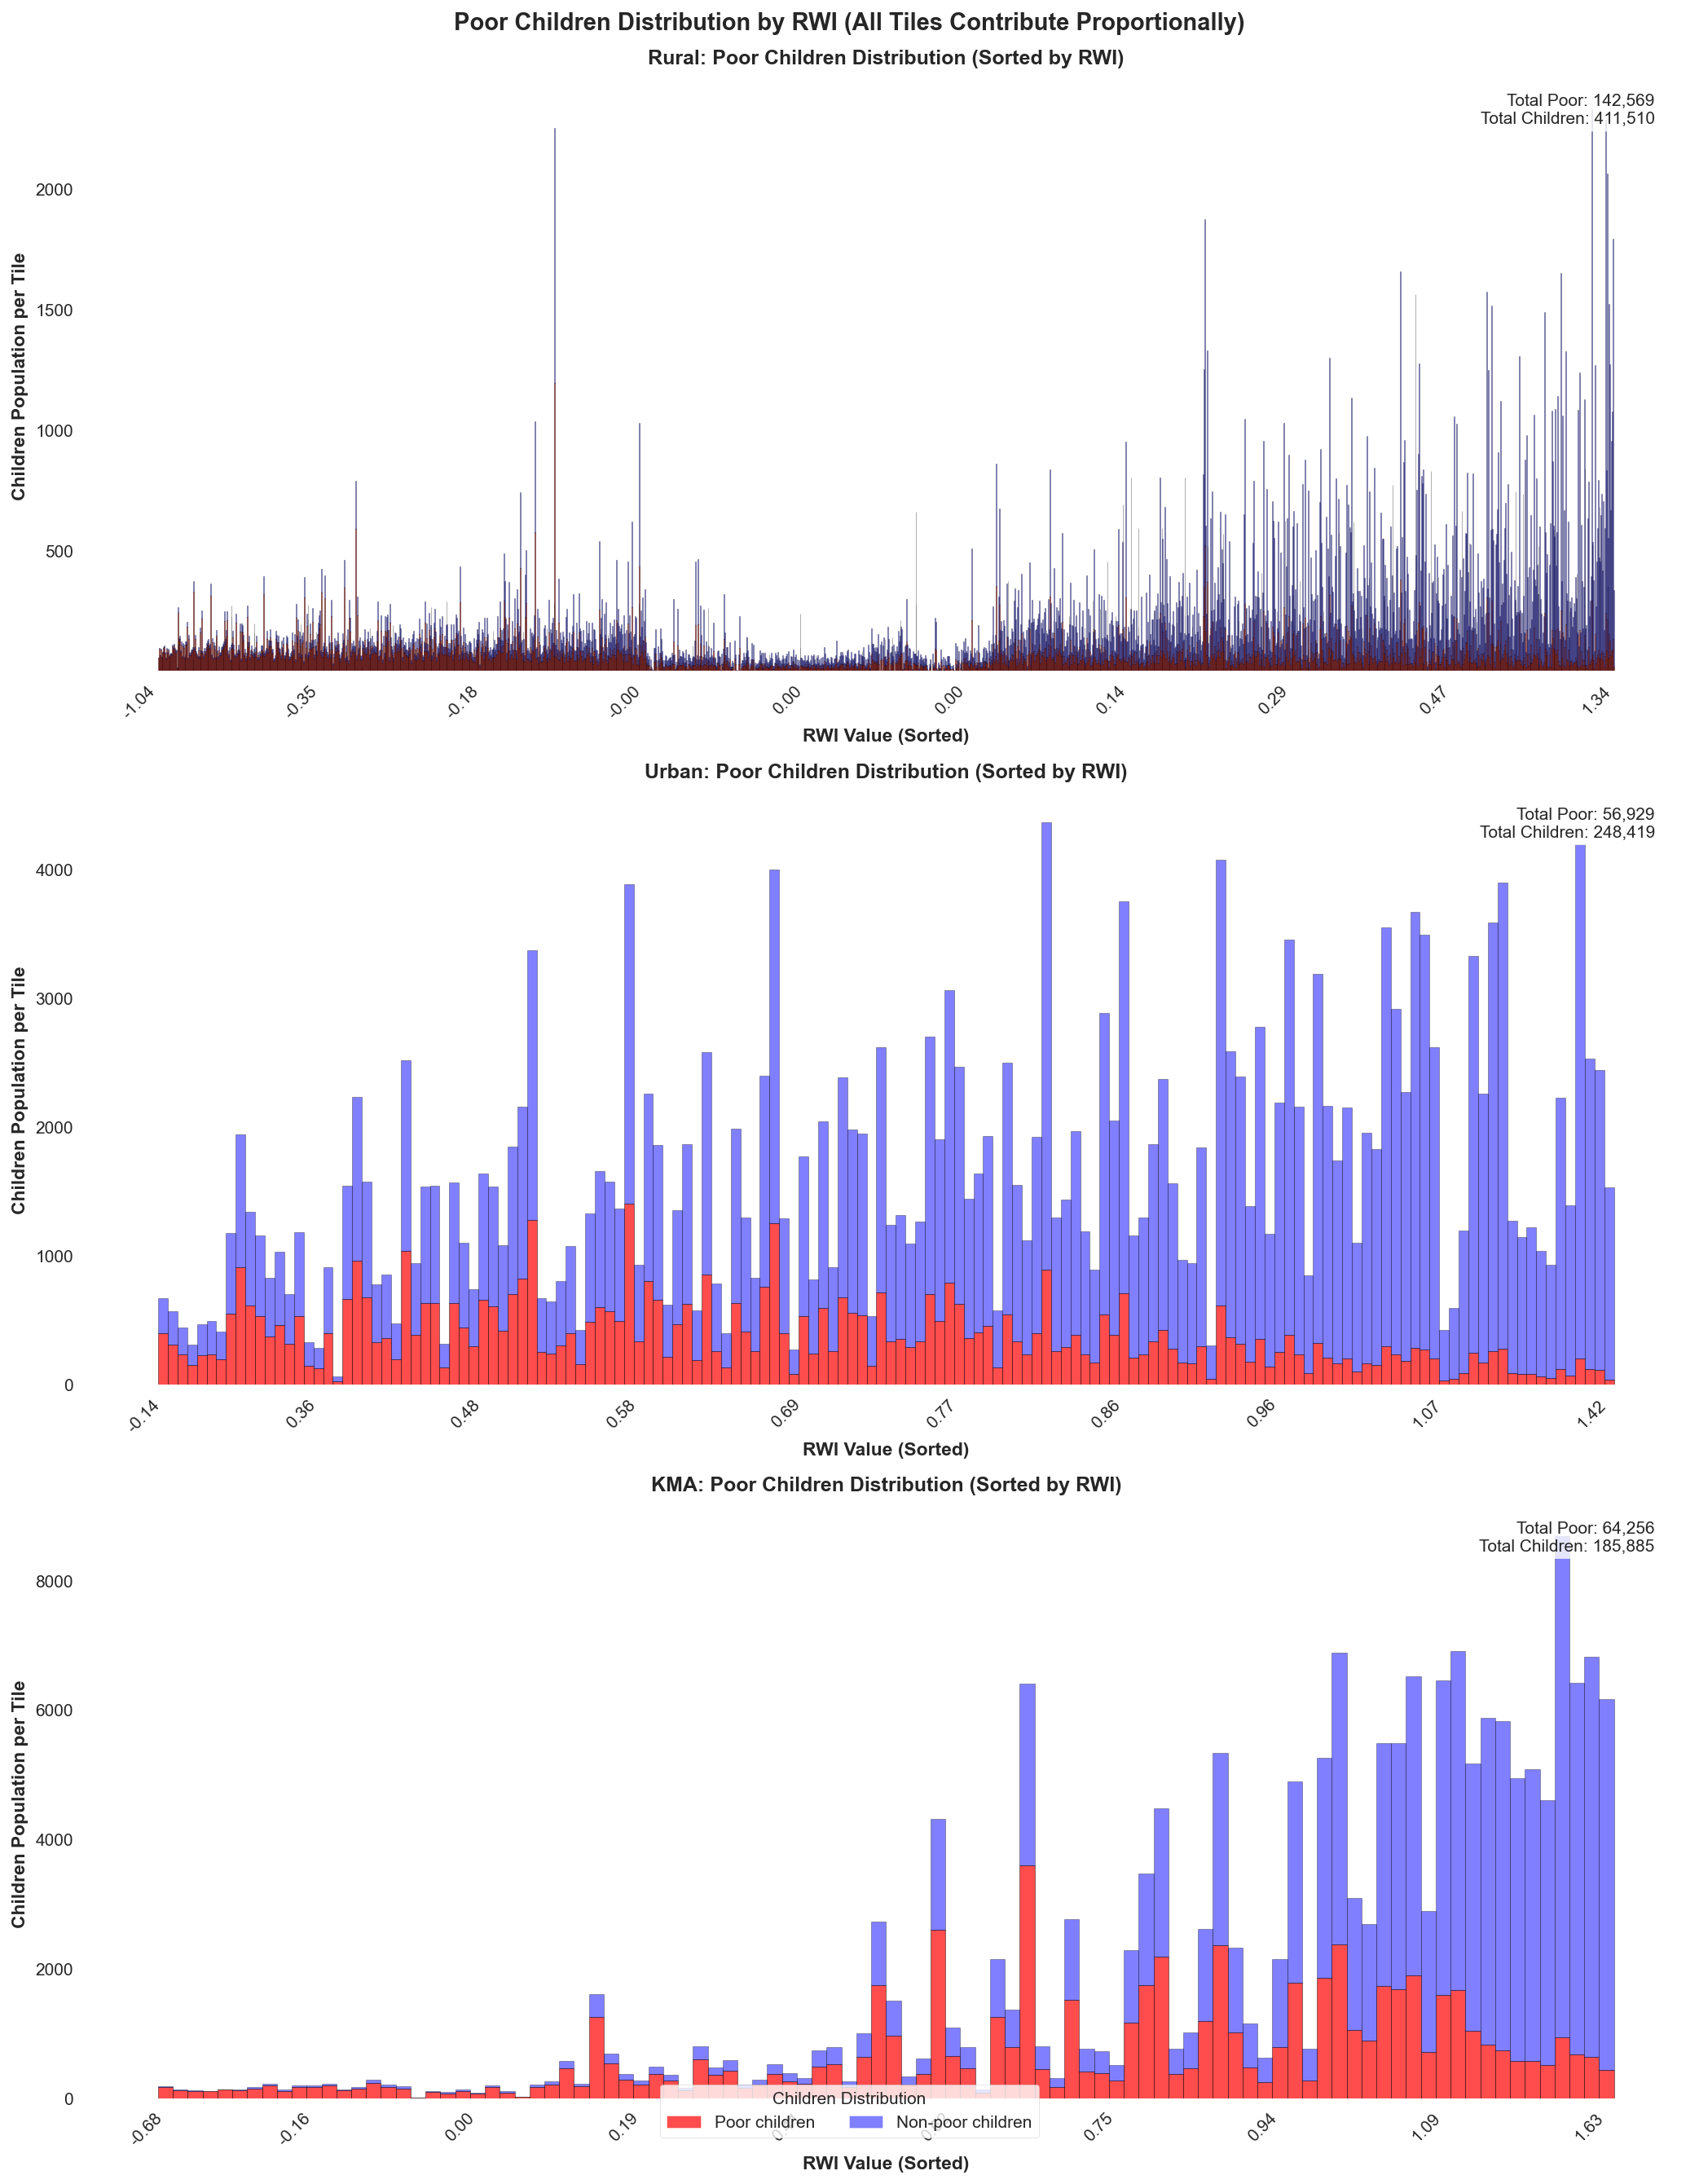

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
plt.subplots_adjust(hspace=0.4, bottom=0.08)

# Collect legend handles and labels
legend_handles = []
legend_labels = []

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    mask = gdf_tiles_with_poor_children['area_classification'] == region
    df_region = gdf_tiles_with_poor_children[mask].copy()
    df_region = df_region.sort_values('rwi').reset_index(drop=True)
    
    ax = axes[idx]
    
    # Calculate poor and non-poor children for each tile
    df_region['poor_children'] = df_region['poverty_prob'] * df_region['children_population']
    df_region['non_poor_children'] = df_region['children_population'] - df_region['poor_children']
    
    # Use evenly spaced positions for bars (not scaled by RWI)
    x_positions = np.arange(len(df_region))
    rwi_values = df_region['rwi'].values
    
    # Plot poor children (red) as bottom of stack
    bars1 = ax.bar(x_positions, df_region['poor_children'].values,
           color='red', alpha=0.7, edgecolor='black', linewidth=0.3,
           width=1.0, label='Poor children')
    if idx == 0 and len(legend_handles) == 0:
        legend_handles.append(Patch(facecolor='red', alpha=0.7, label='Poor children'))
        legend_labels.append('Poor children')
    
    # Plot non-poor children (blue) on top
    bars2 = ax.bar(x_positions, df_region['non_poor_children'].values,
           bottom=df_region['poor_children'].values,
           color='blue', alpha=0.5, edgecolor='black', linewidth=0.3,
           width=1.0, label='Non-poor children')
    if idx == 0 and len(legend_handles) < 2:
        legend_handles.append(Patch(facecolor='blue', alpha=0.5, label='Non-poor children'))
        legend_labels.append('Non-poor children')
    
    # Set x-axis to show RWI values at regular intervals
    num_ticks = min(10, len(df_region))  # Show up to 10 ticks
    tick_indices = np.linspace(0, len(df_region) - 1, num_ticks, dtype=int)
    tick_positions = tick_indices
    tick_labels = [f'{rwi_values[i]:.2f}' for i in tick_indices]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_xlabel('RWI Value (Sorted)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Children Population per Tile', fontsize=11, fontweight='bold')
    ax.set_title(f'{region}: Poor Children Distribution (Sorted by RWI)', fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add summary text
    total_poor_region = df_region['poor_children'].sum()
    total_children_region = df_region['children_population'].sum()
    ax.text(0.98, 0.98, 
            f'Total Poor: {total_poor_region:,.0f}\nTotal Children: {total_children_region:,.0f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add unified legend at the bottom
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=2, 
           bbox_to_anchor=(0.5, 0.02), fontsize=10, frameon=True, title='Children Distribution')

plt.suptitle('Poor Children Distribution by RWI (All Tiles Contribute Proportionally)', 
             fontsize=14, fontweight='bold', y=0.99)

plt.tight_layout()
plt.show()

## Normalized Poor Children Distribution by RWI (Proportion)


  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/normalized_poor_children_distribution_by_rwi_proportion_0-1_7.png


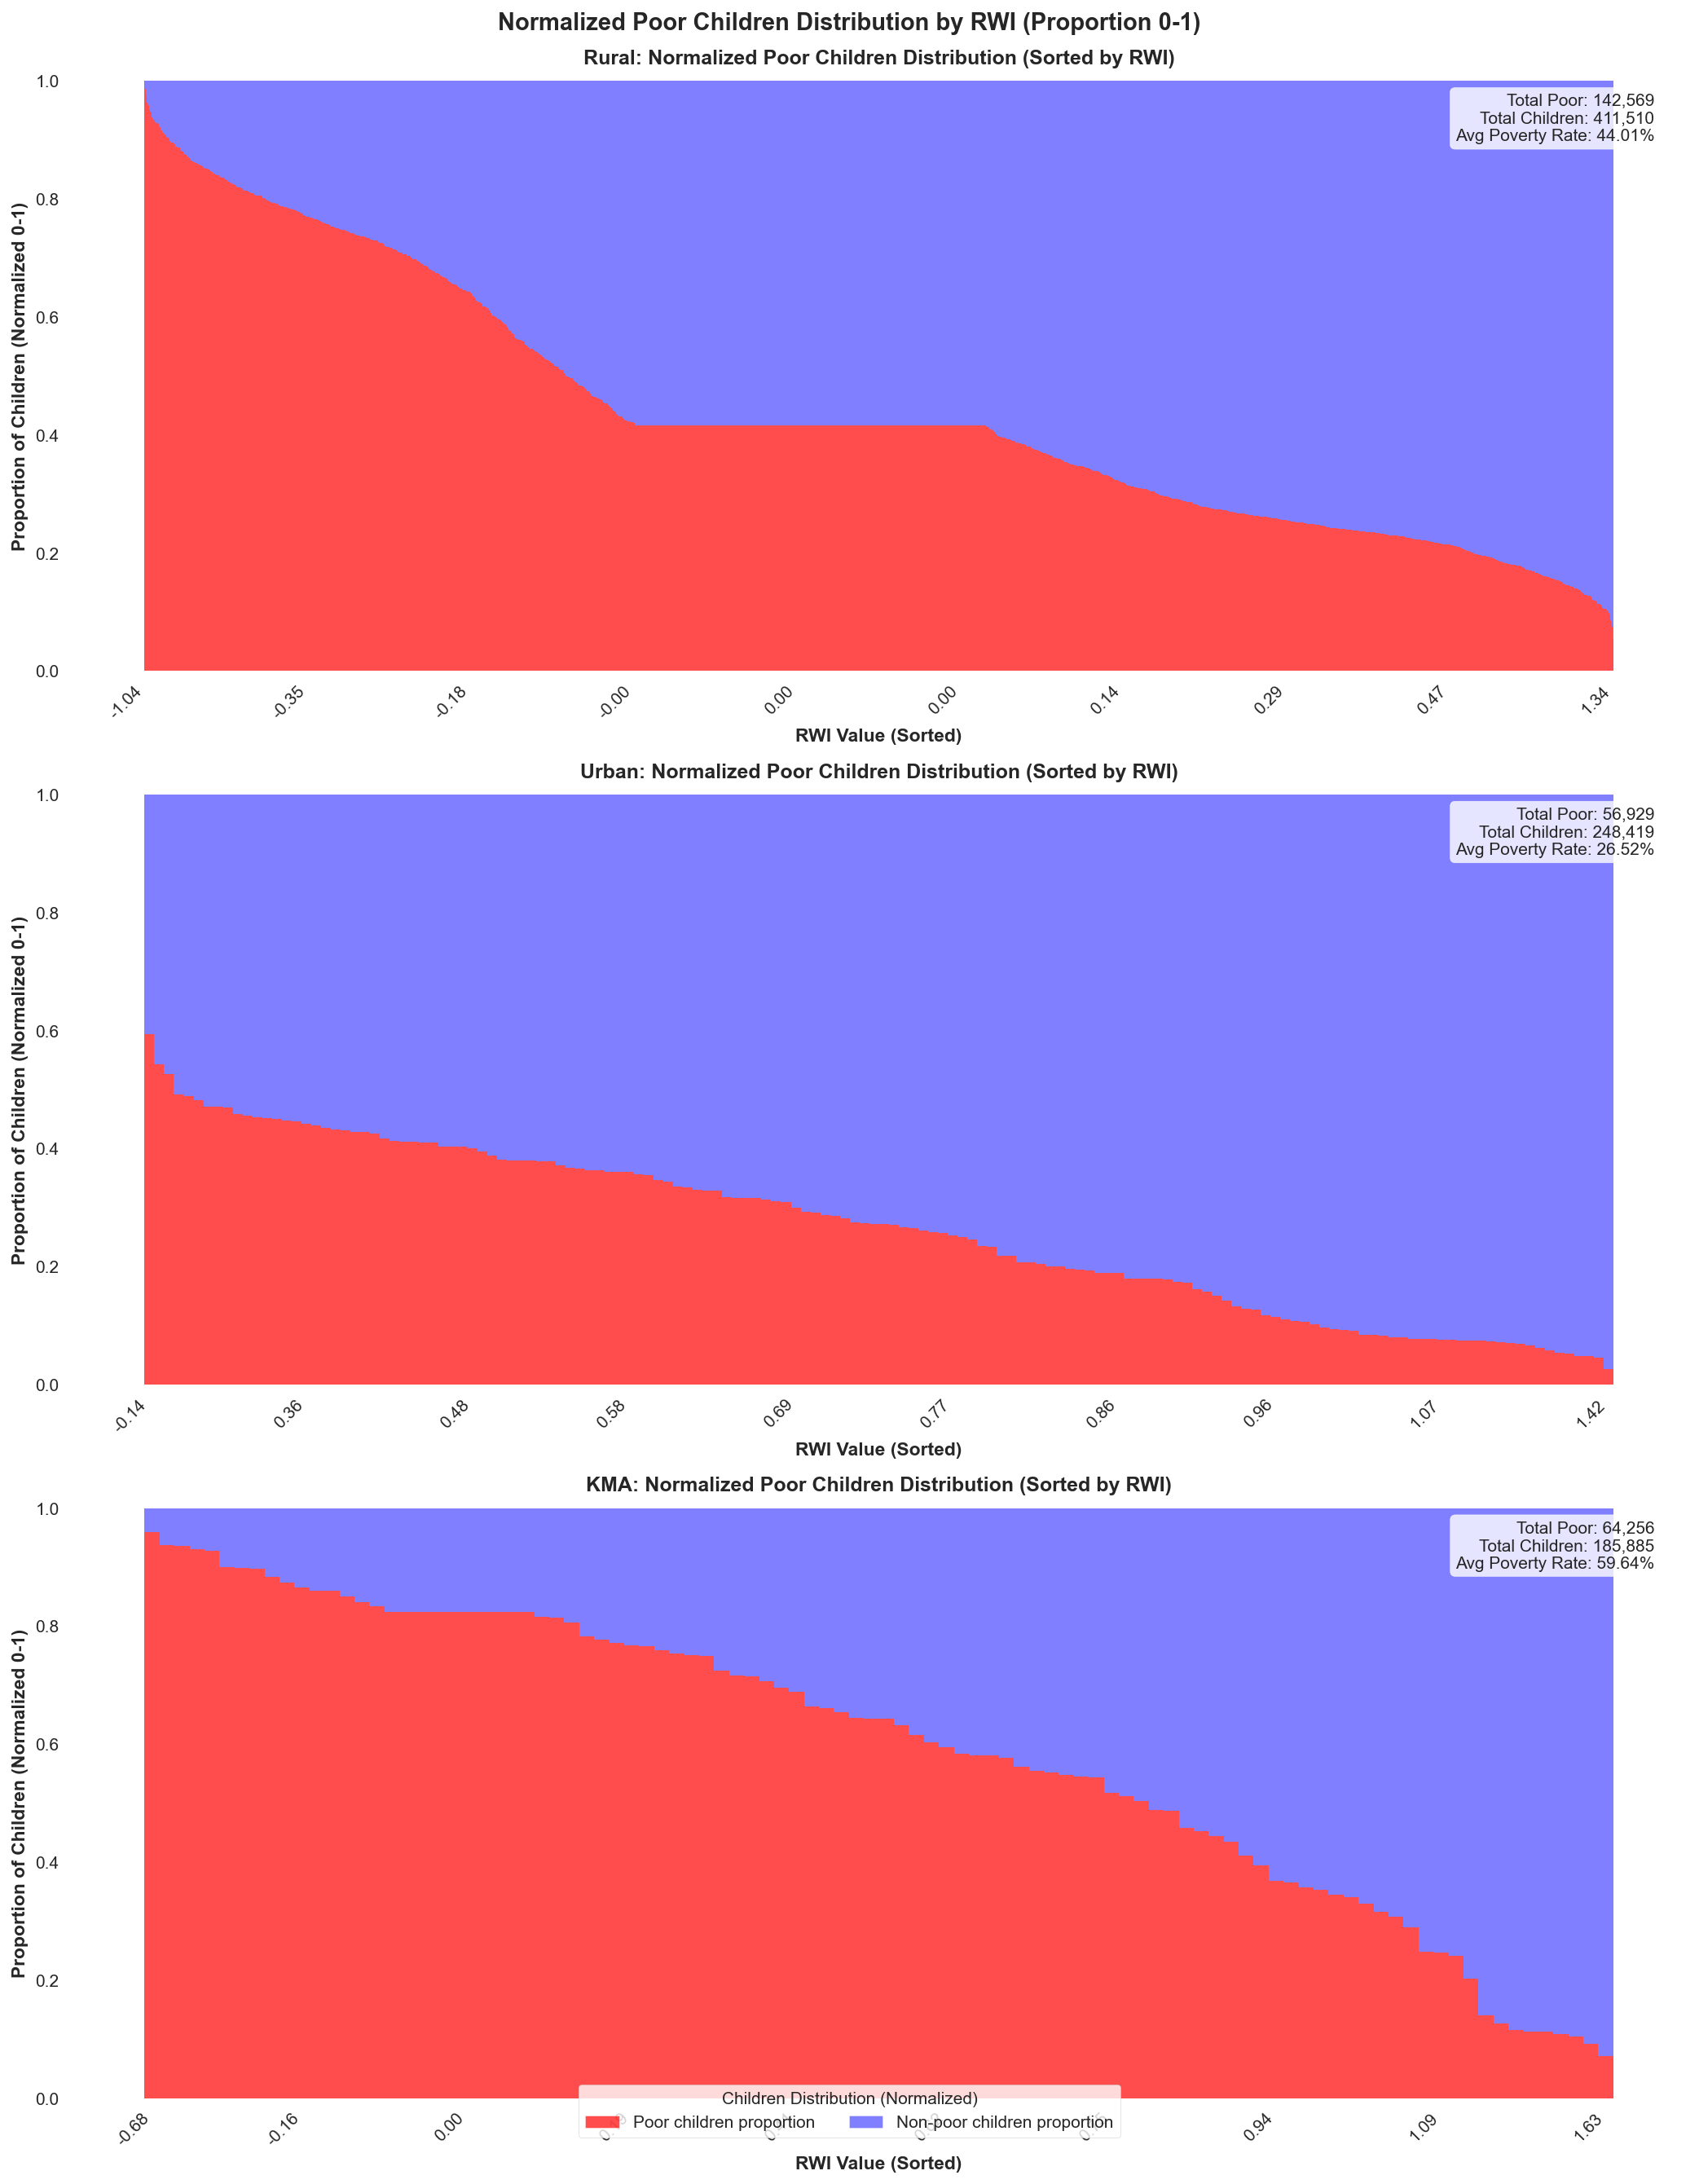

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
plt.subplots_adjust(hspace=0.4, bottom=0.08)

# Collect legend handles and labels
legend_handles = []
legend_labels = []

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    mask = gdf_tiles_with_poor_children['area_classification'] == region
    df_region = gdf_tiles_with_poor_children[mask].copy()
    df_region = df_region.sort_values('rwi').reset_index(drop=True)
    
    ax = axes[idx]
    
    # Calculate poor and non-poor children for each tile
    df_region['poor_children'] = df_region['poverty_prob'] * df_region['children_population']
    df_region['non_poor_children'] = df_region['children_population'] - df_region['poor_children']
    
    # Normalize: convert to proportions (0-1)
    # This shows the poverty rate regardless of population size
    df_region['poor_children_norm'] = df_region['poor_children'] / df_region['children_population']
    df_region['non_poor_children_norm'] = df_region['non_poor_children'] / df_region['children_population']
    
    # Replace NaN with 0 (for tiles with 0 children population)
    df_region['poor_children_norm'] = df_region['poor_children_norm'].fillna(0)
    df_region['non_poor_children_norm'] = df_region['non_poor_children_norm'].fillna(0)
    
    # Use evenly spaced positions for bars (not scaled by RWI)
    x_positions = np.arange(len(df_region))
    rwi_values = df_region['rwi'].values
    
    # Plot poor children proportion (red) as bottom of stack
    bars1 = ax.bar(x_positions, df_region['poor_children_norm'].values,
           color='red', alpha=0.7, edgecolor='black', linewidth=0,
           width=1.0, label='Poor children proportion')
    if idx == 0 and len(legend_handles) == 0:
        legend_handles.append(Patch(facecolor='red', alpha=0.7, label='Poor children proportion'))
        legend_labels.append('Poor children proportion')
    
    # Plot non-poor children proportion (blue) on top
    bars2 = ax.bar(x_positions, df_region['non_poor_children_norm'].values,
           bottom=df_region['poor_children_norm'].values,
           color='blue', alpha=0.5, edgecolor='black', linewidth=0,
           width=1.0, label='Non-poor children proportion')
    if idx == 0 and len(legend_handles) < 2:
        legend_handles.append(Patch(facecolor='blue', alpha=0.5, label='Non-poor children proportion'))
        legend_labels.append('Non-poor children proportion')
    
    # Set x-axis to show RWI values at regular intervals
    num_ticks = min(10, len(df_region))  # Show up to 10 ticks
    tick_indices = np.linspace(0, len(df_region) - 1, num_ticks, dtype=int)
    tick_positions = tick_indices
    tick_labels = [f'{rwi_values[i]:.2f}' for i in tick_indices]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_xlabel('RWI Value (Sorted)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Proportion of Children (Normalized 0-1)', fontsize=11, fontweight='bold')
    ax.set_title(f'{region}: Normalized Poor Children Distribution (Sorted by RWI)', fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])  # Ensure y-axis is 0-1
    
    # Add summary text
    total_poor_region = df_region['poor_children'].sum()
    total_children_region = df_region['children_population'].sum()
    avg_poverty_rate = df_region['poor_children_norm'].mean()
    ax.text(0.98, 0.98, 
            f'Total Poor: {total_poor_region:,.0f}\nTotal Children: {total_children_region:,.0f}\nAvg Poverty Rate: {avg_poverty_rate:.2%}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add unified legend at the bottom
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=2, 
           bbox_to_anchor=(0.5, 0.02), fontsize=10, frameon=True, title='Children Distribution (Normalized)')

plt.suptitle('Normalized Poor Children Distribution by RWI (Proportion 0-1)', 
             fontsize=14, fontweight='bold', y=0.99)

plt.tight_layout()
plt.show()


## Calculate Expected Impacted Poor Children


In [ ]:
# Store impact data for multiple thresholds (tile-level only)
impact_tile_data = {}

# Check if impact configuration variables are defined
try:
    has_impact_config = DATE is not None and FORECAST_TIME is not None and WIND_THRESHOLDS is not None and STORM is not None
except NameError:
    has_impact_config = False

if has_impact_config and DATE and FORECAST_TIME and WIND_THRESHOLDS and STORM:
    date_str = DATE.replace("-", "")
    forecast_datetime_str = f"{date_str}{FORECAST_TIME}"
    
    # Load tile-level data for each wind threshold
    for wind_threshold in WIND_THRESHOLDS:
        tile_impact_file = f"{COUNTRY}_{STORM}_{forecast_datetime_str}_{wind_threshold}_14.csv"
        tile_impact_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", tile_impact_file)
        
        if os.path.exists(tile_impact_path):
            print(f"Loading tile-level impact data for {wind_threshold}kt from: {tile_impact_path}")
            df_tile = pd.read_csv(tile_impact_path)
            zone_cols = [col for col in ['zone_id', 'tile_id', 'tileid', 'tile'] if col in df_tile.columns]
            if not zone_cols or 'probability' not in df_tile.columns:
                print(f"  Tile file missing required columns; {wind_threshold}kt will have 0 impact")
                continue
            zone_col = zone_cols[0]
            impact_tile_data[wind_threshold] = df_tile[[zone_col, 'probability']].rename(columns={zone_col: 'tile_id_source'})
            print(f"  Loaded {len(df_tile)} tile probabilities")
        else:
            print(f"Tile-level impact file not found for {wind_threshold}kt: {tile_impact_path}")
            print(f"  {wind_threshold}kt will have 0 impact (no data available)")
    
    # Process all requested thresholds (even if no data, set impact to 0)
    if WIND_THRESHOLDS:
        # Ensure we have poor_children calculated
        if 'poor_children' not in gdf_tiles_with_poor_children.columns:
            gdf_tiles_with_poor_children['poor_children'] = gdf_tiles_with_poor_children['poverty_prob'] * gdf_tiles_with_poor_children['children_population']
        
        # Attach a helper column for tile-id matching (strip leading zeros for consistency)
        gdf_tiles_with_poor_children['tile_id_match'] = gdf_tiles_with_poor_children['tile_id'].astype(str).str.lstrip('0')
        
        # Merge tile-level probabilities for thresholds with data
        if impact_tile_data:
            print(f"\nMerging tile-level impact probabilities for {len(impact_tile_data)} threshold(s)...")
            for wind_threshold, df_tile in impact_tile_data.items():
                prob_col = f'impact_probability_{wind_threshold}kt'
                impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                df_tile = df_tile.copy()
                df_tile['tile_id_match'] = df_tile['tile_id_source'].astype(str).str.lstrip('0')
                
                # Debug: Check merge keys
                print(f"  Merging {wind_threshold}kt: {len(df_tile)} impact tiles")
                
                # Check if tile_id_match column exists in gdf_tiles_with_poor_children
                if 'tile_id_match' not in gdf_tiles_with_poor_children.columns:
                    print(f"    Creating tile_id_match column...")
                    gdf_tiles_with_poor_children['tile_id_match'] = gdf_tiles_with_poor_children['tile_id'].astype(str).str.lstrip('0')
                
                # Drop existing columns for this threshold if they exist (to avoid merge suffix issues)
                cols_to_drop = [c for c in gdf_tiles_with_poor_children.columns 
                               if c.startswith(prob_col) or c.startswith(impact_col)]
                if cols_to_drop:
                    print(f"    Dropping existing columns: {cols_to_drop}")
                    gdf_tiles_with_poor_children = gdf_tiles_with_poor_children.drop(columns=cols_to_drop)
                
                # Prepare merge dataframe - rename probability column first
                df_merge = pd.DataFrame({
                    'tile_id_match': df_tile['tile_id_match'].values,
                    prob_col: df_tile['probability'].values  # Use 'probability' before rename
                })
                
                # Perform merge using pandas merge on the underlying DataFrame
                # Convert to DataFrame temporarily to avoid GeoDataFrame merge issues
                gdf_temp = gdf_tiles_with_poor_children.copy()
                df_temp = pd.DataFrame(gdf_temp.drop(columns='geometry'))
                df_merged = df_temp.merge(
                    df_merge,
                    on='tile_id_match',
                    how='left'
                )
                
                # Restore geometry and convert back to GeoDataFrame
                df_merged['geometry'] = gdf_tiles_with_poor_children['geometry'].values
                gdf_tiles_with_poor_children = gpd.GeoDataFrame(df_merged, geometry='geometry', crs=gdf_tiles_with_poor_children.crs)
                
                # Handle pandas merge suffixes if they exist (shouldn't happen now, but just in case)
                if prob_col not in gdf_tiles_with_poor_children.columns:
                    # Check for _y suffix (new column from merge)
                    prob_col_y = f'{prob_col}_y'
                    if prob_col_y in gdf_tiles_with_poor_children.columns:
                        gdf_tiles_with_poor_children[prob_col] = gdf_tiles_with_poor_children[prob_col_y]
                        gdf_tiles_with_poor_children = gdf_tiles_with_poor_children.drop(columns=[prob_col_y])
                    else:
                        print(f"    ERROR: Column {prob_col} not found after merge!")
                        print(f"    Available columns: {[c for c in gdf_tiles_with_poor_children.columns if 'impact' in c.lower() or 'prob' in c.lower()]}")
                        continue
                
                # Check how many matches were found
                matches = gdf_tiles_with_poor_children[prob_col].notna().sum()
                print(f"    Matched {matches} out of {len(gdf_tiles_with_poor_children)} tiles ({matches/len(gdf_tiles_with_poor_children)*100:.1f}%)")
                
                # Calculate expected impacted poor children at TILE LEVEL:
                # Impact = Poor Children x Impact Probability
                # Keep as float to preserve precision (round only at final aggregation)
                gdf_tiles_with_poor_children[impact_col] = (
                    gdf_tiles_with_poor_children['poor_children'] * gdf_tiles_with_poor_children[prob_col]
                ).fillna(0)
        
        # For thresholds without data, set impact to 0
        for wind_threshold in WIND_THRESHOLDS:
            impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
            if impact_col not in gdf_tiles_with_poor_children.columns:
                # No data available for this threshold, set impact to 0
                gdf_tiles_with_poor_children[impact_col] = 0
        
        # Aggregate impact data by classification for summary
        impact_summary = []
        for classification in ['KMA', 'Urban', 'Rural']:
            classification_tiles = gdf_tiles_with_poor_children[gdf_tiles_with_poor_children['area_classification'] == classification]
            
            if len(classification_tiles) > 0:
                row = {
                    'classification': classification,
                    'total_poor_children': classification_tiles['poor_children'].sum()
                }
                for wind_threshold in WIND_THRESHOLDS:
                    impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                    row[impact_col] = classification_tiles[impact_col].sum()
                impact_summary.append(row)
        
        # Report totals for each threshold
        print(f"\nImpact probability processing complete for {len(WIND_THRESHOLDS)} threshold(s)")
        for wind_threshold in WIND_THRESHOLDS:
            impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
            if impact_col in gdf_tiles_with_poor_children.columns:
                total = gdf_tiles_with_poor_children[impact_col].sum()
                if total > 0:
                    print(f"   {wind_threshold}kt: Total potentially impacted poor children: {total:,.0f}")
                else:
                    print(f"   {wind_threshold}kt: Total potentially impacted poor children: 0 (no data available)")
else:
    print("Impact probability configuration not set (DATE, FORECAST_TIME, WIND_THRESHOLDS, STORM)")
    print("   Skipping impact probability calculation")


Loading tile-level impact data for 34kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_34_14.csv
  Loaded 2231 tile probabilities
Loading tile-level impact data for 50kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_50_14.csv
  Loaded 2231 tile probabilities
Loading tile-level impact data for 64kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_64_14.csv
  Loaded 2231 tile probabilities

Merging tile-level impact probabilities for 3 threshold(s)...
  Merging 34kt: 2231 impact tiles
    Dropping existing columns: ['impact_probability_34kt', 'potentially_impacted_poor_children_34kt']
    Matched 2224 out of 2224 tiles (100.0%)
  Merging 50kt: 2231 impact tiles
    Dropping existing columns: ['impact_probability_50kt', 'potentially_impacted_poor_children_50kt']
    Matched 2224 out of 2224 tiles (100.0%)
  Merging 64kt: 2231 impact tiles
    Dropping existing columns: ['impact_probability_64kt', 'potentially_impacted_poor_c

## Expected Impacted Poor Children by Parish



Parish Impact Summary:
         parish  total_tiles  poor_children
      Clarendon          240   29763.479818
        Hanover          100    6460.283614
       Kingston            4    7198.847279
     Manchester          159   16261.949543
       Portland          171    9715.836637
   Saint Andrew           94   57057.025733
      Saint Ann          240   17228.521792
Saint Catherine          239   43409.201028
Saint Elizabeth          235   16906.418287
    Saint James          119   12391.895764
     Saint Mary          131   13102.947656
   Saint Thomas          157   11812.367387
       Trelawny          170    7547.099286
   Westmoreland          165   14898.401690
  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/expected_impacted_poor_children_by_parish_and_wind_threshold_8.png


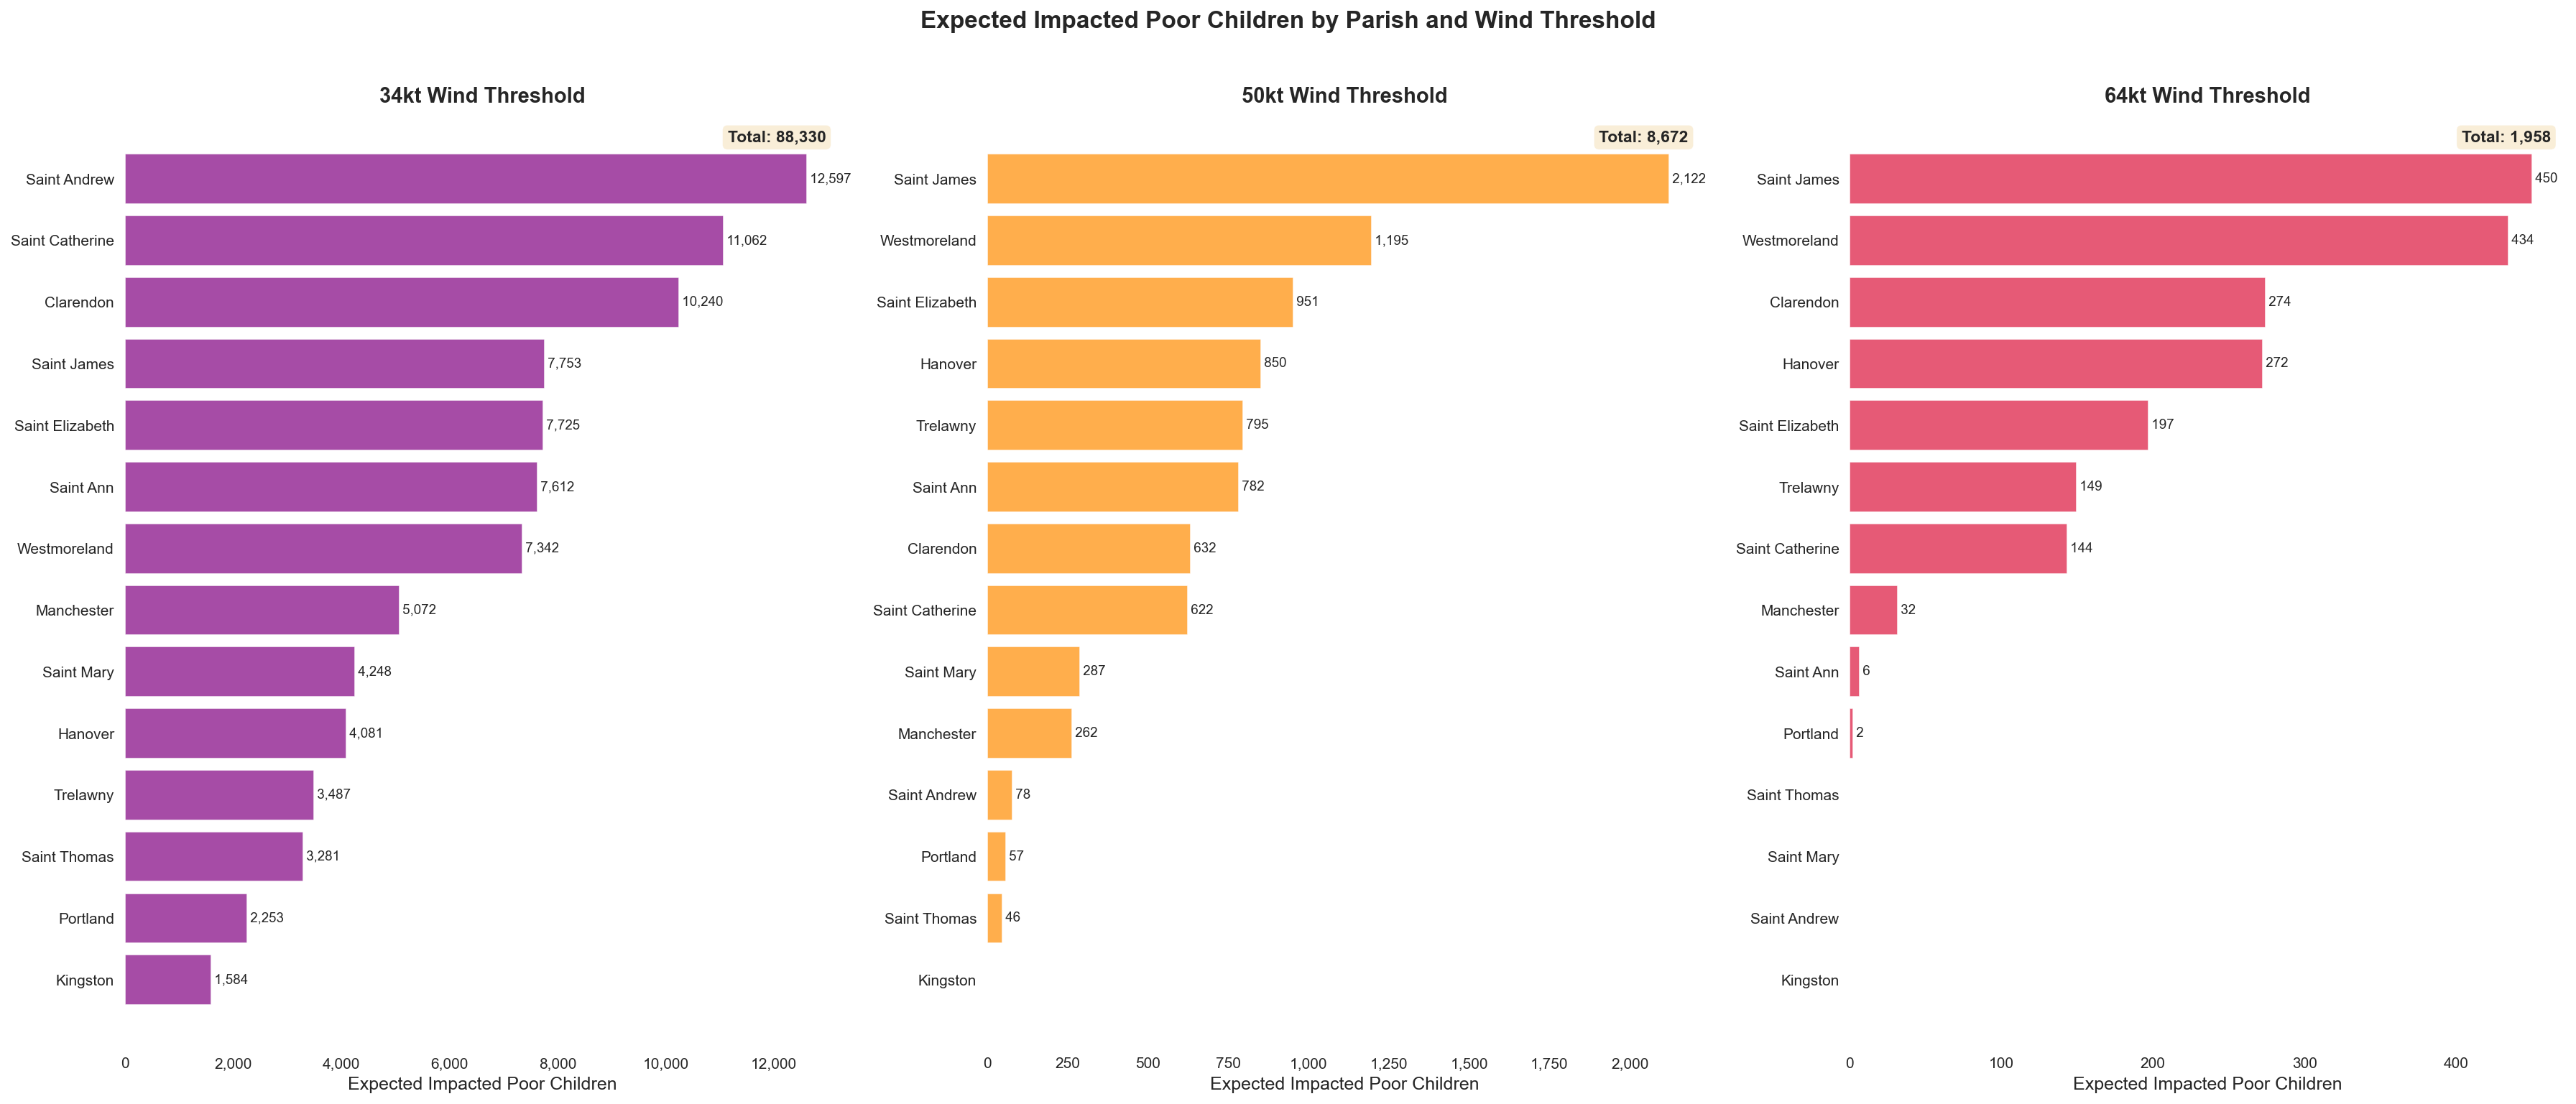

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/expected_impacted_poor_children_comparison_across_wind_thresholds_by_parish_9.png


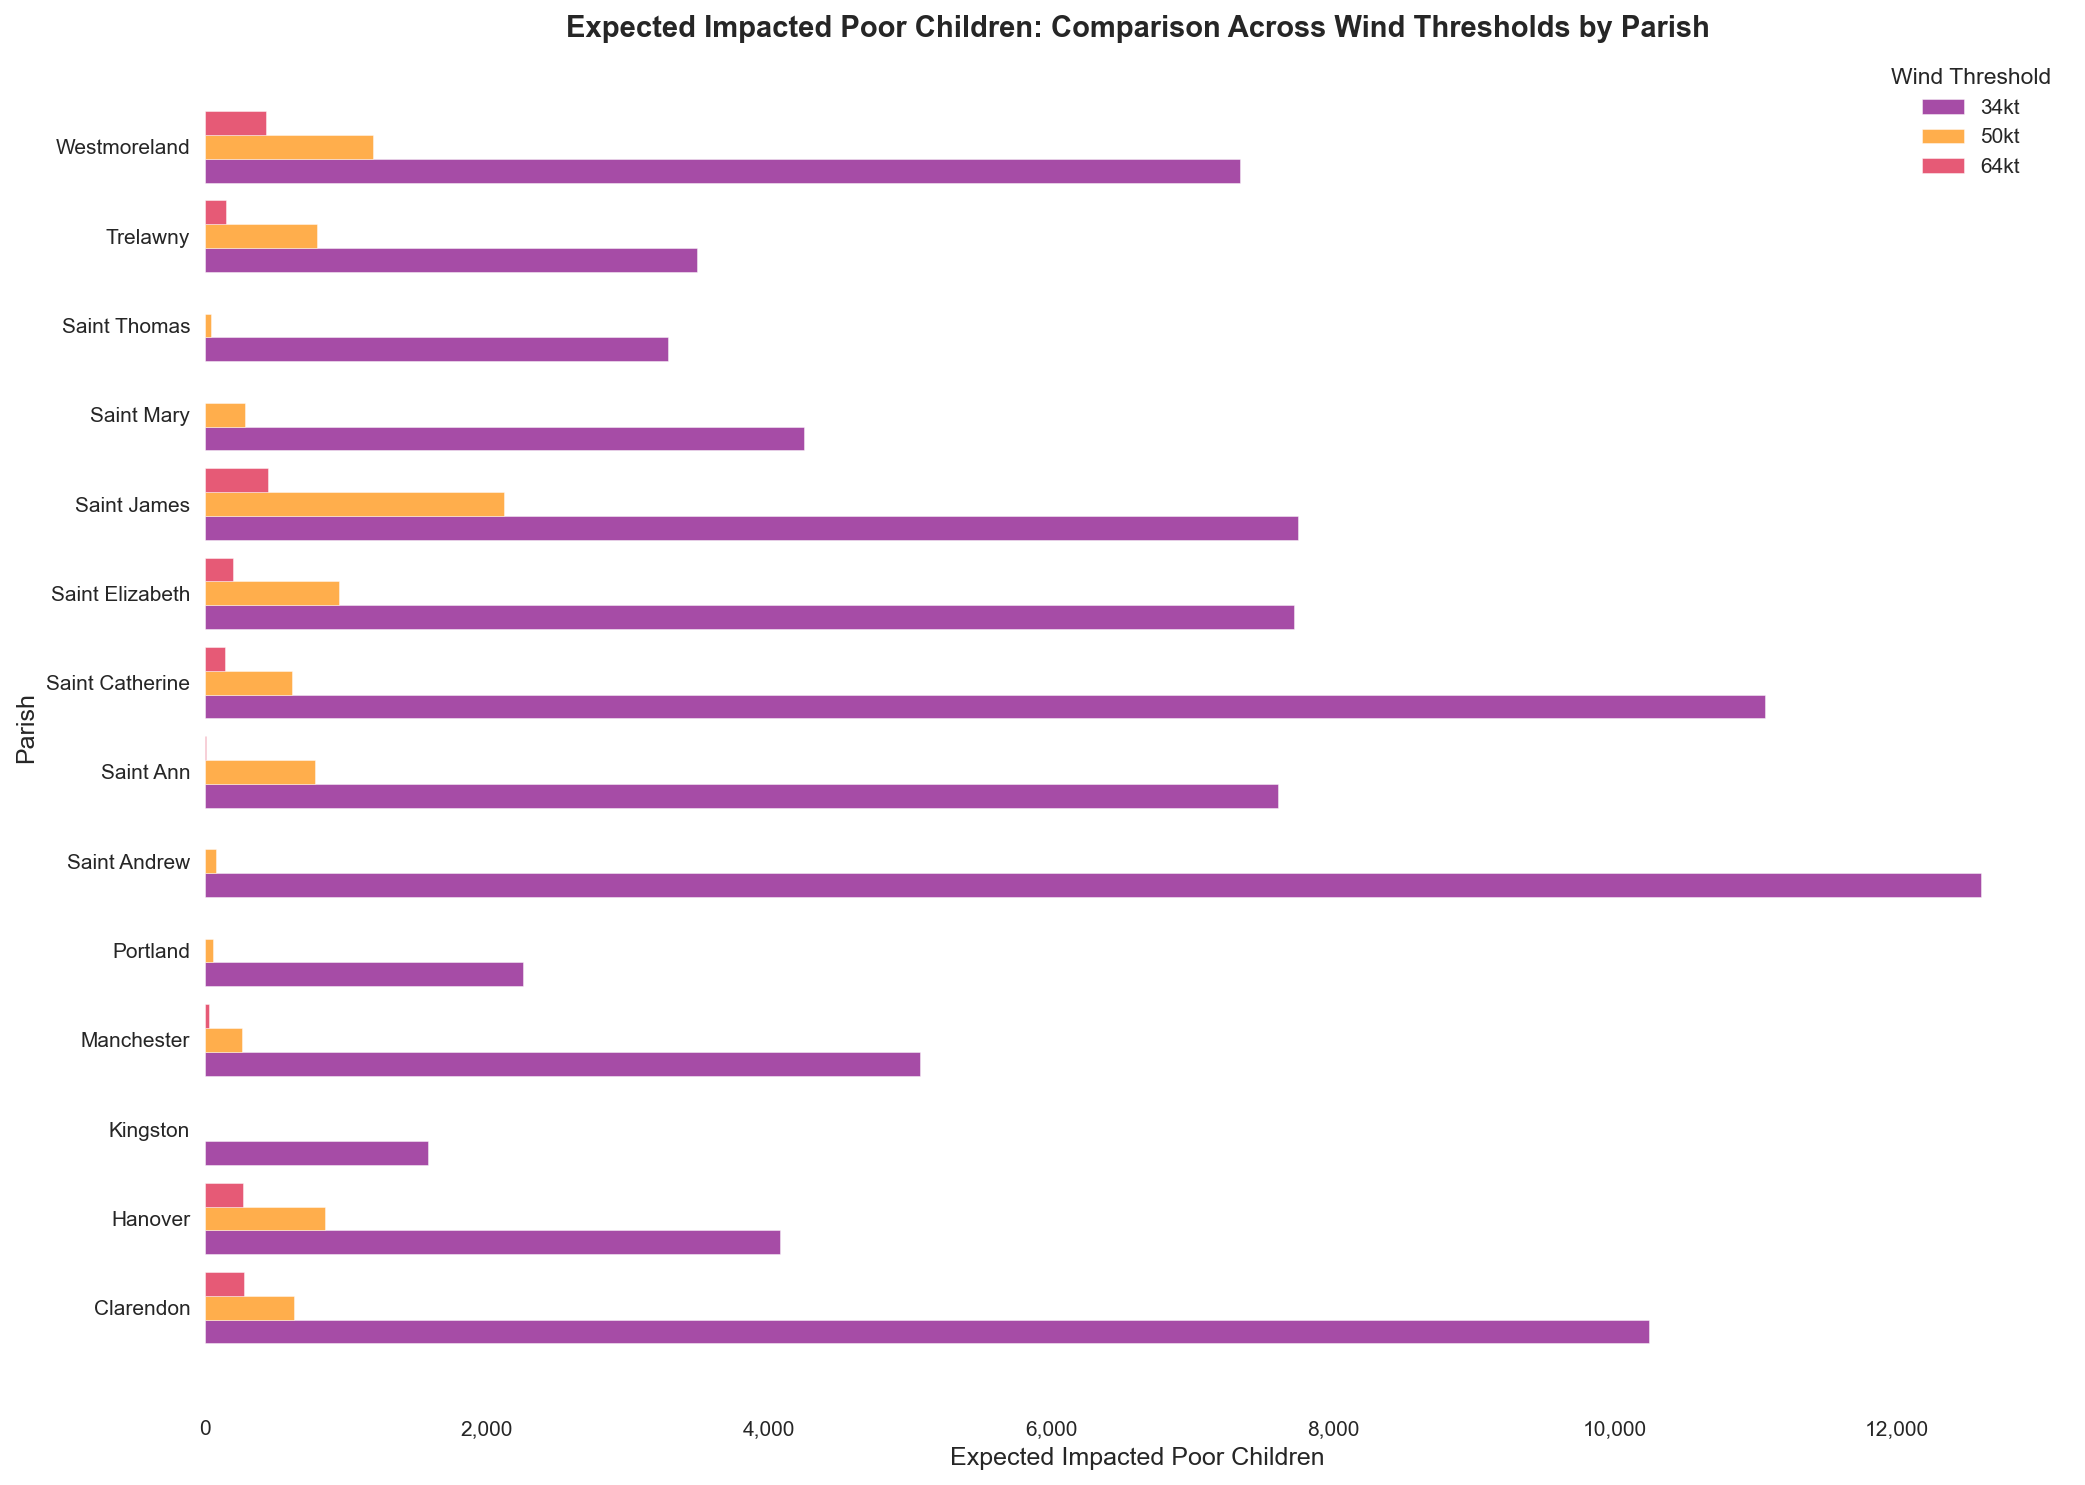

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/34kt_wind_threshold_-_expected_impacted_poor_children_by_parish_10.png


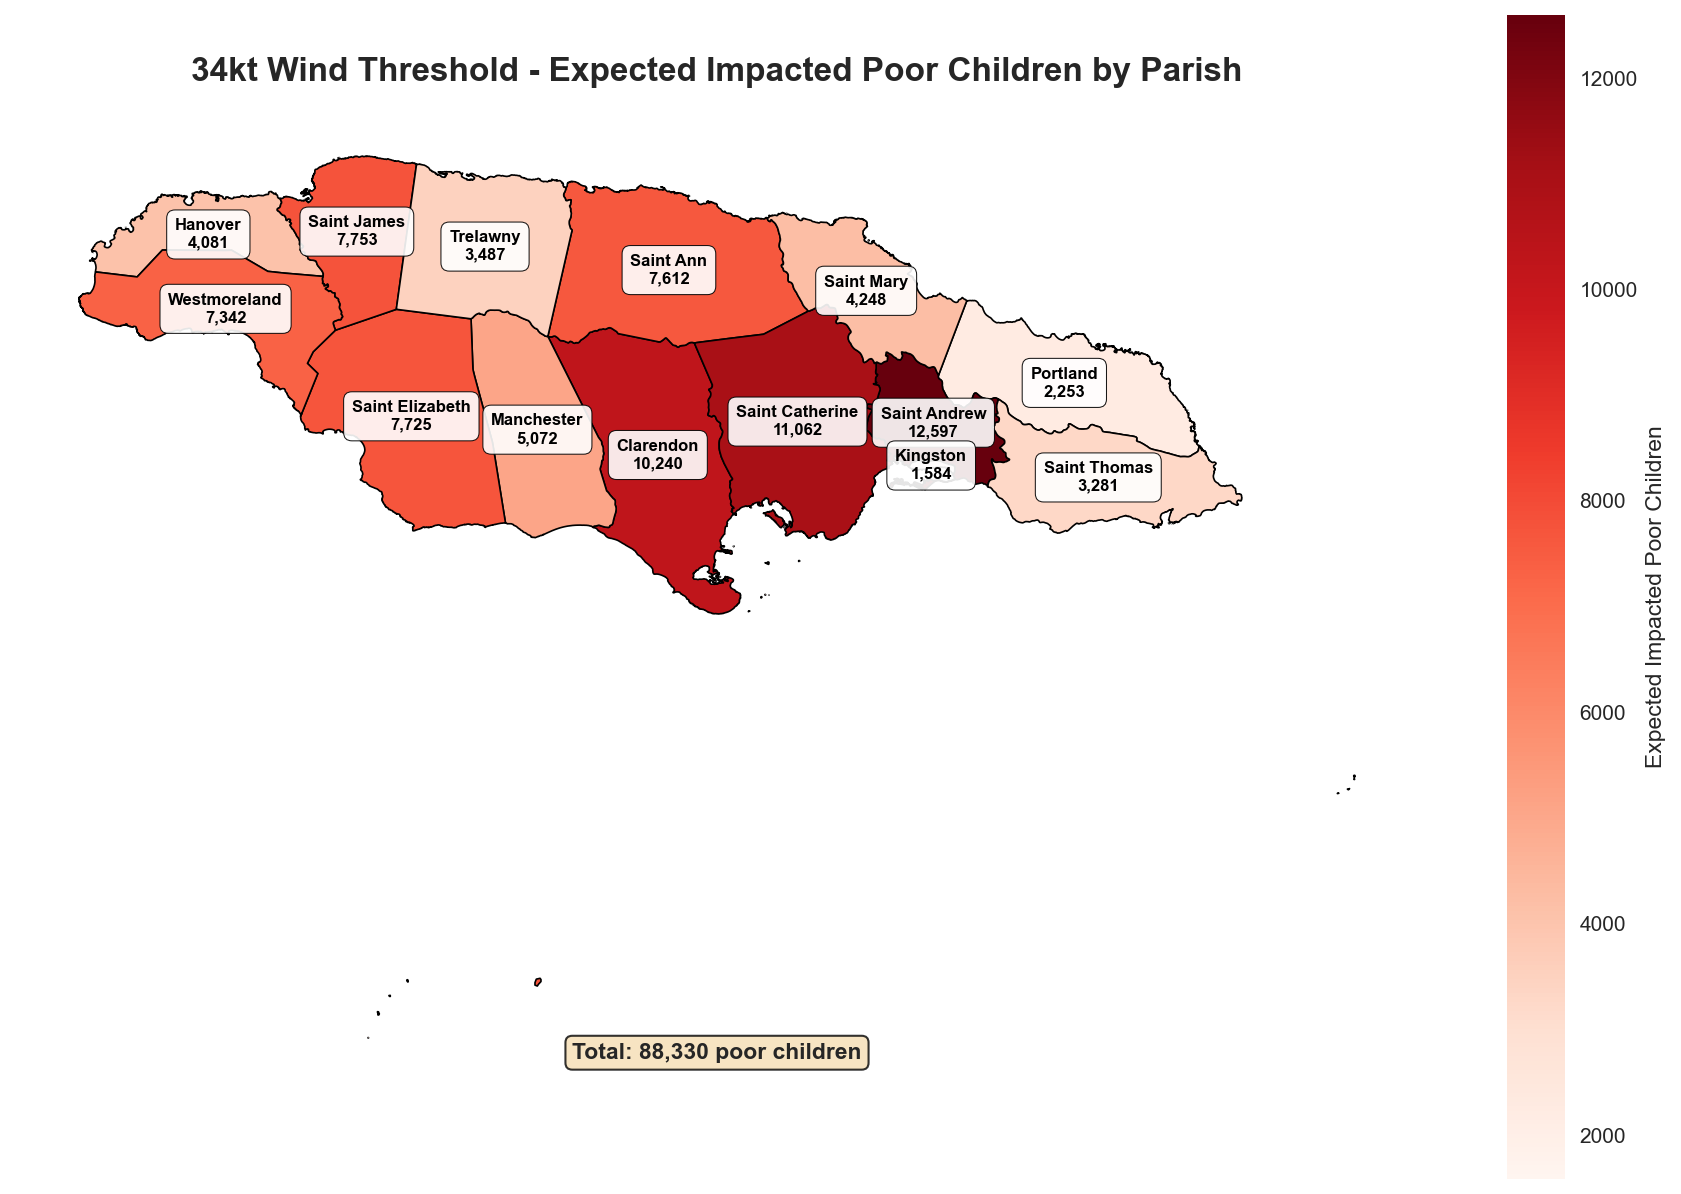

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/50kt_wind_threshold_-_expected_impacted_poor_children_by_parish_11.png


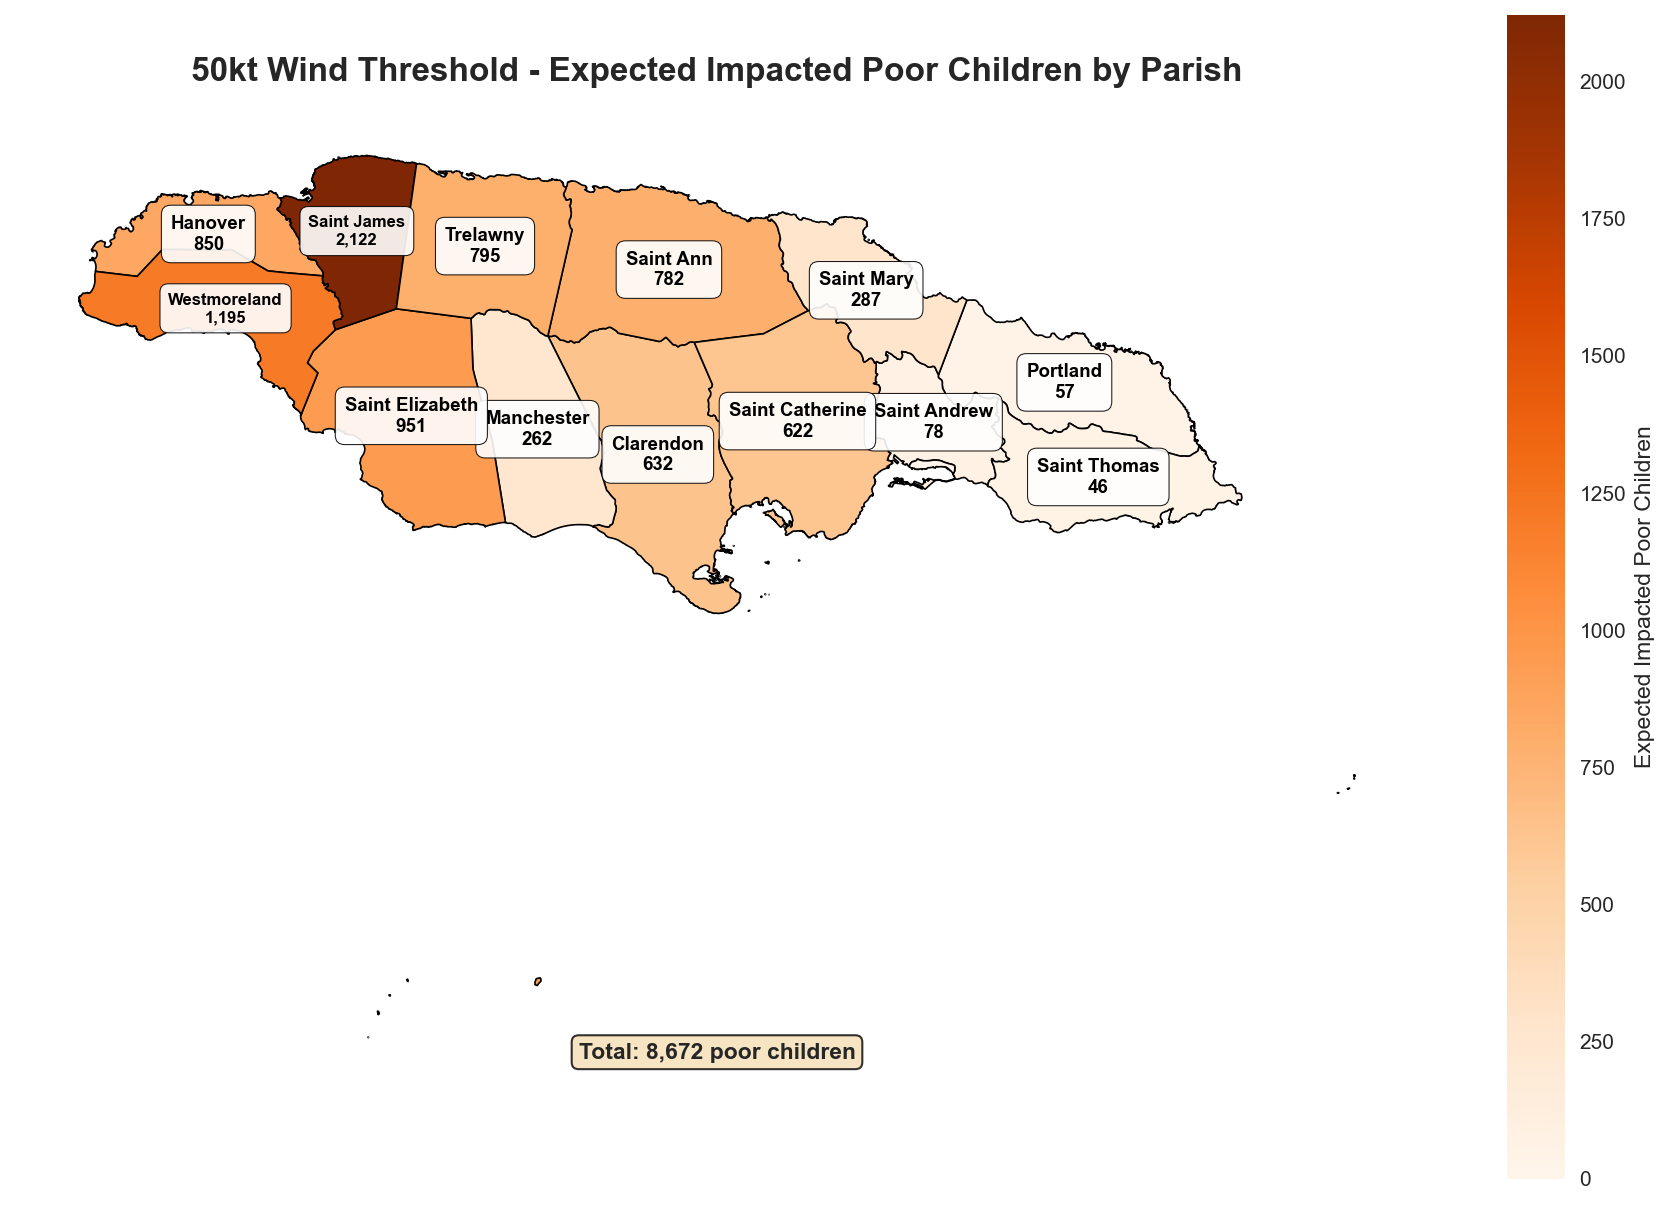

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/64kt_wind_threshold_-_expected_impacted_poor_children_by_parish_12.png


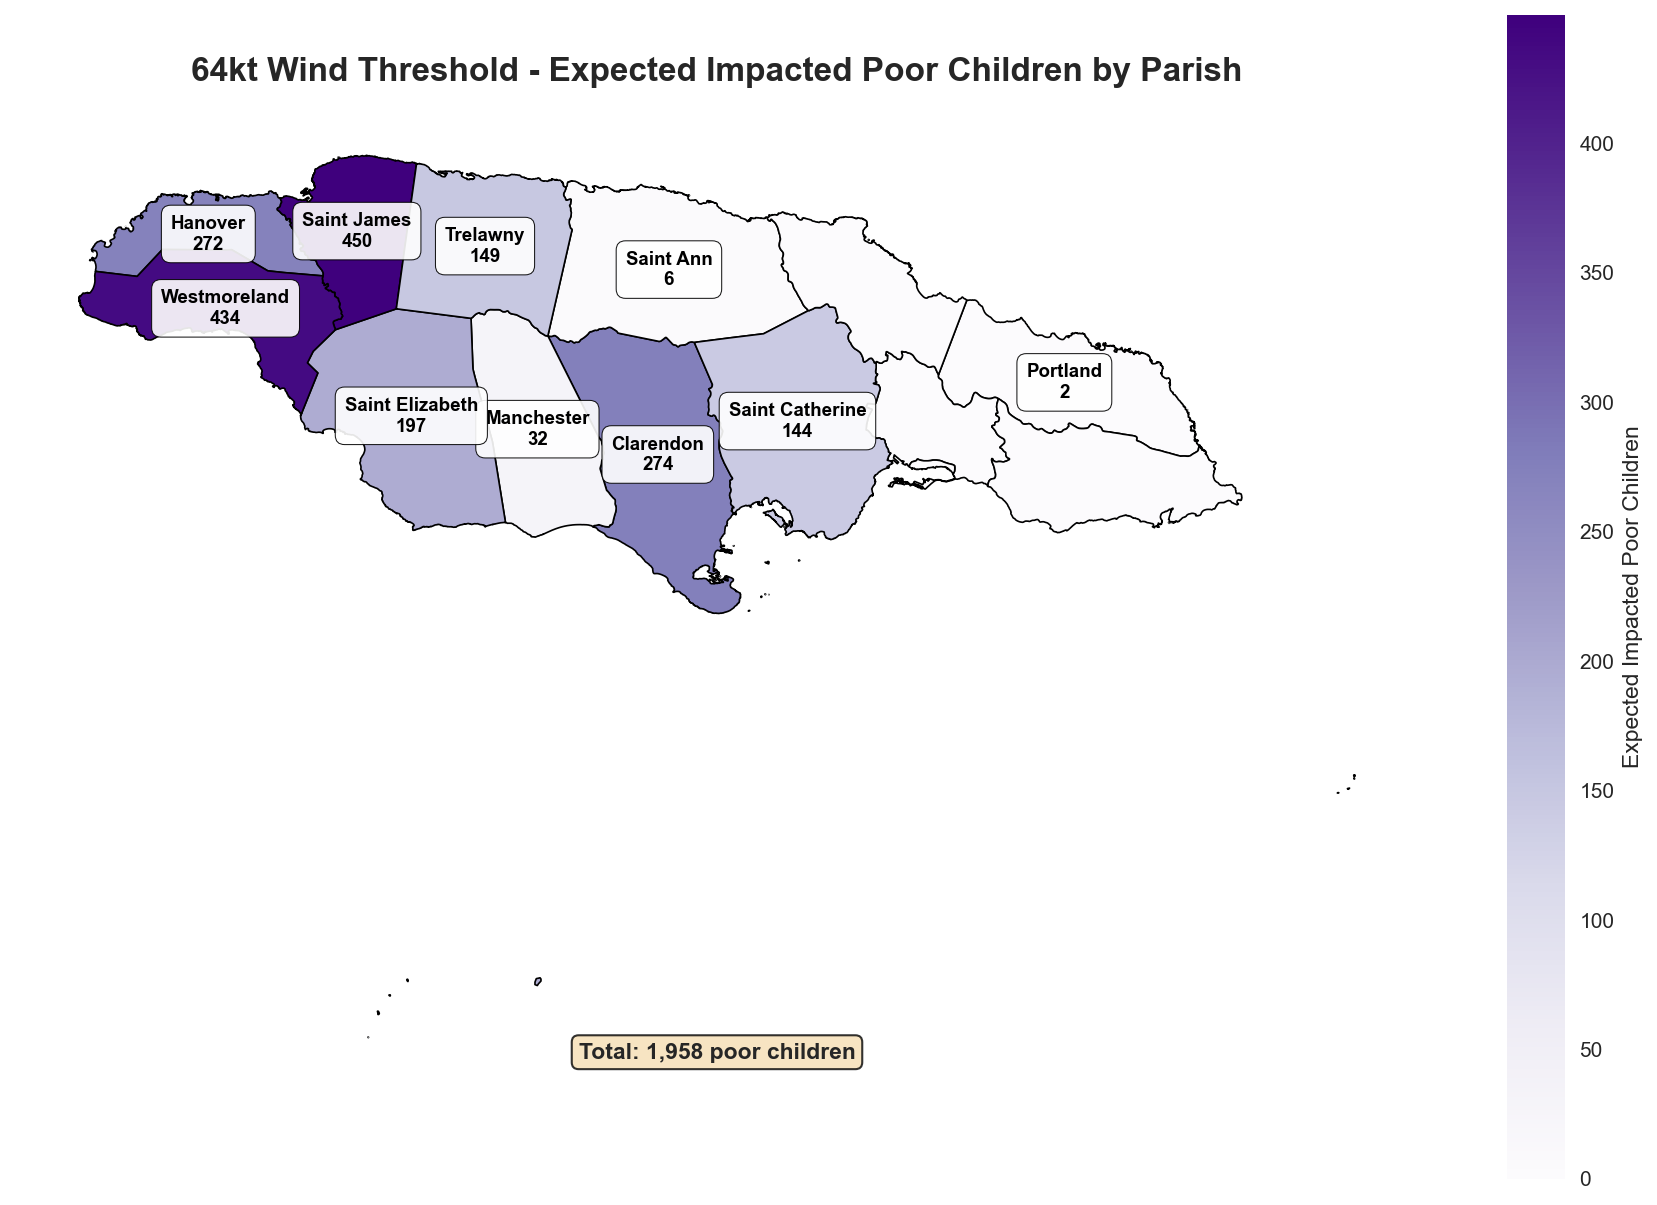

In [ ]:
try:
    has_impact_config = DATE is not None and FORECAST_TIME is not None and WIND_THRESHOLDS is not None and STORM is not None
except NameError:
    has_impact_config = False

has_impact_data = (has_impact_config and DATE and FORECAST_TIME and WIND_THRESHOLDS and STORM and 
                   any(f'potentially_impacted_poor_children_{wt}kt' in gdf_tiles_with_poor_children.columns 
                       for wt in WIND_THRESHOLDS))

if has_impact_data:
    # Aggregate by parish (ALL tiles contribute proportionally)
    parish_impact_summary = []
    
    for parish_name in sorted(gdf_tiles_with_poor_children['parish'].unique()):
        parish_tiles = gdf_tiles_with_poor_children[gdf_tiles_with_poor_children['parish'] == parish_name]
        
        if len(parish_tiles) > 0:
            row = {
                'parish': parish_name,
                'total_tiles': len(parish_tiles),
                'poor_children': parish_tiles['poor_children'].sum()
            }
            
            # Add impact data for each threshold - compute fresh at tile level for accuracy
            for wind_threshold in WIND_THRESHOLDS:
                impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                prob_col = f'impact_probability_{wind_threshold}kt'
                # Compute fresh: poor_children × impact_probability (at tile level, then sum)
                if prob_col in parish_tiles.columns:
                    row[impact_col] = (parish_tiles['poor_children'] * parish_tiles[prob_col]).sum()
                else:
                    row[impact_col] = 0
            
            parish_impact_summary.append(row)
    
    df_parish_impact = pd.DataFrame(parish_impact_summary)
    
    print(f"\nParish Impact Summary:")
    print(df_parish_impact[['parish', 'total_tiles', 'poor_children']].to_string(index=False))
    
    # Create visualizations per parish for each wind threshold
    impact_pop_cols = [col for col in df_parish_impact.columns if col.startswith('potentially_impacted_poor_children_')]
    
    if impact_pop_cols:
        # Determine layout based on number of thresholds
        n_thresholds = len(impact_pop_cols)
        
        if n_thresholds == 1:
            fig, axes = plt.subplots(1, 1, figsize=(14, 10))
            axes = [axes]
        elif n_thresholds == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        elif n_thresholds == 3:
            fig, axes = plt.subplots(1, 3, figsize=(24, 10))
        else:
            n_cols = 3
            n_rows = (n_thresholds + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
            axes = axes.flatten()
        
        colors = ['purple', 'darkorange', 'crimson', 'teal', 'navy', 'maroon']
        
        for idx, impact_col in enumerate(impact_pop_cols):
            ax = axes[idx]
            threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
            
            # Sort by impact poor children
            df_plot = df_parish_impact.sort_values(impact_col, ascending=True)
            
            # Create horizontal bar chart
            bars = ax.barh(df_plot['parish'], df_plot[impact_col], color=colors[idx % len(colors)], alpha=0.7)
            
            # Add value labels on bars (round up)
            for i, (bar, val) in enumerate(zip(bars, df_plot[impact_col])):
                if val > 0:
                    ax.text(val, i, f' {np.ceil(val):,.0f}', va='center', fontsize=9)
            
            ax.set_xlabel('Expected Impacted Poor Children', fontsize=12)
            ax.set_title(f'{threshold}kt Wind Threshold', fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            
            # Add total at the top (round up)
            total = df_parish_impact[impact_col].sum()
            ax.text(0.98, 0.98, f'Total: {np.ceil(total):,.0f}', 
                   transform=ax.transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=11, fontweight='bold')
        
        # Hide unused subplots
        for idx in range(n_thresholds, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('Expected Impacted Poor Children by Parish and Wind Threshold',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Create side-by-side comparison
        fig, ax = plt.subplots(figsize=(14, 10))
        
        parishes = df_parish_impact['parish'].values
        x = np.arange(len(parishes))
        width = 0.8 / n_thresholds
        
        for idx, impact_col in enumerate(impact_pop_cols):
            threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
            values = df_parish_impact[impact_col].values
            offset = (idx - (n_thresholds - 1) / 2) * width
            ax.barh(x + offset, values, width, label=f'{threshold}kt', 
                   color=colors[idx % len(colors)], alpha=0.7)
        
        ax.set_xlabel('Expected Impacted Poor Children', fontsize=12)
        ax.set_ylabel('Parish', fontsize=12)
        ax.set_title('Expected Impacted Poor Children: Comparison Across Wind Thresholds by Parish',
                    fontsize=14, fontweight='bold')
        ax.set_yticks(x)
        ax.set_yticklabels(parishes)
        ax.legend(title='Wind Threshold', fontsize=10, title_fontsize=11)
        ax.grid(axis='x', alpha=0.3)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        plt.tight_layout()
        plt.show()

        
        # Create map visualizations for expected impacted poor children by parish (AGGREGATED)
        
        # Use df_parish_impact which already has the computed values (computed fresh at tile level)
        # This ensures consistency with impact_pop_cols and avoids data mismatch
        
        if 'gdf_admin' not in locals() or gdf_admin is None:
            admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")
            if os.path.exists(admin_base_path):
                gdf_admin = gpd.read_parquet(admin_base_path)
                print(f"Loaded admin boundaries: {len(gdf_admin)} parishes")
            else:
                print(f"Warning: Admin boundaries file not found at {admin_base_path}")
                gdf_admin = None
        
        # Join impact data to admin boundaries for mapping
        # Use df_parish_impact which already has all the computed impact columns
        if gdf_admin is not None:
            gdf_admin_impact = gdf_admin.merge(df_parish_impact, left_on='name', right_on='parish', how='left')
            
            colormaps = ['Reds', 'Oranges', 'Purples', 'Blues', 'Greens', 'YlOrRd']
            
            # Create separate map visualization for each wind threshold
            for idx, impact_col in enumerate(impact_pop_cols):
                threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
                
                # Create a separate figure for each threshold
                fig, ax = plt.subplots(1, 1, figsize=(12, 10))
                
                # Plot admin boundaries colored by potentially impacted poor children
                gdf_admin_impact.plot(
                    ax=ax,
                    column=impact_col,
                    cmap=colormaps[idx % len(colormaps)],
                    edgecolor='black',
                    linewidth=0.8,
                    legend=True,
                    legend_kwds={
                        'label': 'Expected Impacted Poor Children',
                        'shrink': 0.8
                    },
                    missing_kwds={
                        'color': 'lightgray',
                        'edgecolor': 'black',
                        'hatch': '///',
                        'label': 'No data'
                    }
                )
                
                # Add parish labels (round up, display if value > 0)
                if impact_col in gdf_admin_impact.columns:
                    label_count = 0
                    for idx_parish, row in gdf_admin_impact.iterrows():
                        val = row[impact_col]
                        # Check if value exists and is greater than 0
                        if pd.notna(val) and val > 0:
                            centroid = row.geometry.centroid
                            rounded_val = np.ceil(val)
                            # Only display if rounded value is at least 1
                            if rounded_val >= 1:
                                # Use larger font for better visibility, especially for larger numbers
                                font_size = 9 if rounded_val < 1000 else 8
                                ax.text(
                                    centroid.x, centroid.y,
                                    f"{row['name']}\n{rounded_val:,.0f}",
                                    ha='center', va='center',
                                    fontsize=font_size,
                                    fontweight='bold',
                                    color='black',
                                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.5)
                                )
                                label_count += 1
                
                ax.set_title(f'{threshold}kt Wind Threshold - Expected Impacted Poor Children by Parish', 
                           fontsize=16, fontweight='bold', pad=15)
                ax.set_xlabel('Longitude', fontsize=11)
                ax.set_ylabel('Latitude', fontsize=11)
                ax.axis('off')
                
                # Add total at the bottom (round up)
                total = gdf_admin_impact[impact_col].sum() if impact_col in gdf_admin_impact.columns else 0
                ax.text(0.5, 0.02, f'Total: {np.ceil(total):,.0f} poor children', 
                       transform=ax.transAxes, ha='center', va='bottom',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1),
                       fontsize=11, fontweight='bold')
                
                plt.tight_layout()
                plt.show()
        else:
            print("Skipping map visualization - admin boundaries not available")
        
    else:
        print("No impact probability columns found in parish data")
else:
    print("No impact probability data available for parish-level visualization")


## Comprehensive Summary Table: Parish-Level Impact Analysis

In [20]:
# Check if we have impact data
has_impact_data = False
impact_cols = []
hur_50kt_col = None
if 'gdf_tiles_with_poor_children' in locals():
    for col in gdf_tiles_with_poor_children.columns:
        if col.startswith('impact_probability_') and col.endswith('kt'):
            has_impact_data = True
            impact_cols.append(col)
            # Find 50kt column specifically
            if '50kt' in col:
                hur_50kt_col = col
    
    if hur_50kt_col:
        print(f"Using 50kt wind threshold for hurricane impact: {hur_50kt_col}")
    elif impact_cols:
        print(f"Warning: 50kt threshold not found. Available thresholds: {impact_cols}")
        print(f"  Using first available threshold: {impact_cols[0]}")
        hur_50kt_col = impact_cols[0]
    print()

# Aggregate data by parish
parish_summary = []

for parish_name in sorted(gdf_tiles_with_poor_children['parish'].unique()):
    parish_tiles = gdf_tiles_with_poor_children[gdf_tiles_with_poor_children['parish'] == parish_name]
    
    if len(parish_tiles) == 0:
        continue
    
    # Children data (ages 0-15) - actual data from tiles
    total_children = parish_tiles['children_population'].sum()
    total_poor_children = parish_tiles['poor_children'].sum()  # This is: poverty_prob x children_population
    
    # Calculate child poverty rate
    child_poverty_rate = (total_poor_children / total_children * 100) if total_children > 0 else 0
    
    # Impact data - use 50kt wind threshold for hurricane impact
    affected_children_hur = 0
    affectation_rate_hur = 0
    chin_hur = 0  # Children In Need (affected poor children)
    
    if has_impact_data and hur_50kt_col and hur_50kt_col in parish_tiles.columns:
        # Calculate affected children based on 50kt impact probability (at tile level)
        # Affected Children: children_population x impact_probability_50kt
        affected_children_hur = (parish_tiles['children_population'] * parish_tiles[hur_50kt_col]).sum()
        
        # Calculate affectation rate (weighted average impact probability for children)
        total_children_weight = parish_tiles['children_population'].sum()
        affectation_rate_hur = (parish_tiles['children_population'] * parish_tiles[hur_50kt_col]).sum() / total_children_weight * 100 if total_children_weight > 0 else 0
        
        # CHIN (Children In Need) - compute fresh at tile level for accuracy
        # Compute at tile level: poor_children × impact_probability_50kt, then sum (preserves precision)
        chin_hur = (parish_tiles['poor_children'] * parish_tiles[hur_50kt_col]).sum()
    
    parish_summary.append({
        'Parish and Constituency': parish_name,
        'Total Children': np.ceil(total_children),
        '% affectation expected HUR (50kt)': affectation_rate_hur,
        'Affected Children': np.ceil(affected_children_hur),
        'Child poverty rates (%)': child_poverty_rate,
        'CHIN': np.ceil(chin_hur)  # Children In Need (affected poor children from 50kt hurricane)
    })

# Create DataFrame
df_parish_summary = pd.DataFrame(parish_summary)

# Compute totals from original unrounded data (before rounding in the dataframe)
# This ensures accuracy - sum first, then round up (not round then sum)
total_children_unrounded = sum([parish_tiles['children_population'].sum() 
                                for parish_name in sorted(gdf_tiles_with_poor_children['parish'].unique())
                                for parish_tiles in [gdf_tiles_with_poor_children[gdf_tiles_with_poor_children['parish'] == parish_name]]
                                if len(parish_tiles) > 0])

affected_children_unrounded = 0
chin_unrounded = 0
if has_impact_data and hur_50kt_col and hur_50kt_col in gdf_tiles_with_poor_children.columns:
    # Compute totals fresh at tile level
    affected_children_unrounded = (gdf_tiles_with_poor_children['children_population'] * gdf_tiles_with_poor_children[hur_50kt_col]).sum()
    chin_unrounded = (gdf_tiles_with_poor_children['poor_children'] * gdf_tiles_with_poor_children[hur_50kt_col]).sum()

# Add Total row - use unrounded totals, then round up
total_row = {
    'Parish and Constituency': 'Total',
    'Total Children': np.ceil(total_children_unrounded),
    '% affectation expected HUR (50kt)': '',  # Leave blank for total
    'Affected Children': np.ceil(affected_children_unrounded),
    'Child poverty rates (%)': (chin_unrounded / affected_children_unrounded * 100) if affected_children_unrounded > 0 else 0,
    'CHIN': np.ceil(chin_unrounded)
}

# Insert total row at the beginning
df_parish_summary = pd.concat([pd.DataFrame([total_row]), df_parish_summary], ignore_index=True)

# Format the table for display
print("="*120)
print("COMPREHENSIVE PARISH-LEVEL IMPACT ANALYSIS SUMMARY")
print("="*120)
print()

# Display formatted table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Format numbers for display
df_display = df_parish_summary.copy()
for col in ['Total Children', 'Affected Children', 'CHIN']:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"{x:,.0f}" if pd.notna(x) and isinstance(x, (int, float)) else "")

for col in ['% affectation expected HUR (50kt)']:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"{x:.0f}%" if pd.notna(x) and isinstance(x, (int, float)) and x > 0 else "")

for col in ['Child poverty rates (%)']:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"{x:.1f}%" if pd.notna(x) and isinstance(x, (int, float)) else "")

print(df_display.to_string(index=False))
print()

# Export to CSV
output_dir = "analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation"
os.makedirs(output_dir, exist_ok=True)
summary_file = os.path.join(output_dir, "comprehensive_parish_summary_table.csv")
df_parish_summary.to_csv(summary_file, index=False)
print(f"\nExported comprehensive summary table to: {summary_file}")


Using 50kt wind threshold for hurricane impact: impact_probability_50kt

COMPREHENSIVE PARISH-LEVEL IMPACT ANALYSIS SUMMARY

Parish and Constituency Total Children % affectation expected HUR (50kt) Affected Children Child poverty rates (%)  CHIN
                  Total        845,815                                              35,483                   24.4% 8,672
              Clarendon         83,314                                2%             1,738                   35.7%   632
                Hanover         23,921                               15%             3,613                   27.0%   850
               Kingston         25,544                                                   0                   28.2%     0
             Manchester         57,745                                1%               626                   28.2%   262
               Portland         25,172                                1%               192                   38.6%    57
           Saint Andrew     